# 친절한 디퓨전 모델 1편: DDPM 이론편
---
2023.08.27 조준우(metamath@gmail.com)







In [51]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from PIL import Image


import plotly.io
import plotly.graph_objects as go

# colab: coloab
# jupyter lab: jupyterlab
# jupyter notebook, quarto blog: notebook
plotly.io.renderers.default = "colab"


2022년 8월 [스테이블 디퓨전](https://stability.ai/blog/stable-diffusion-announcement)이 발표되고  약 1년이 지난 지금 [스테이블 디퓨전 모델을 실행하는 툴](https://github.com/AUTOMATIC1111/stable-diffusion-webui) 사용법에 대한 동영상이 유튜브에 넘쳐나고, 해당 툴로 만들어진 수많은 이미지들이 [civitai](https://civitai.com/) 같은 사이트에 모델과 함께 개시되고 있습니다. AI 기술이 실 생활에도 영향을 미칠 정도로 발전했다는 것을 보여주는 사례이며 2022년에 발표된 스테이블 디퓨전이 이런 현상을 주도했습니다.

2023년 현재 인공지능 학습은 파인튜닝을 중심으로 재편되고 있는것 같습니다.  이전에는 인공지능 알고리즘의 원리를 정확히 파악하고 이를 구현하는 것이 목적이었다면 이제는 모델을 자기 목적에 맞게 파인튜닝할 수 있는것이 더 중요한 목표가 되었습니다. 앞서 이야기한 많은 디퓨전 관련 컨텐츠들도 모두 파인튜닝을 이용한 것들입니다. 파인튜닝을 잘하기 위해서 어느 정도 모델의 원리를 이해할 필요가 있습니다. 하지만 처음부터 모델을 구현할 정도로 원리를 깊게 이해할 필요는 없습니다. 이런 생각에는 여러 이견이 있을 수 있지만 학습의 트랜드가 파인튜닝을 중심으로 변하고 있다는 사실 자체를 부인할 수는 없을 것 같습니다.

트랜드를 따라가는 것도 중요한 일이지만 조금 뒤처져서 여유있게 이전과 마찬가지로 모델의 원리를 납득할 만한 수준, 다시말해 원리를 이해하고 이해한 원리가 맞는지 코드로 실행해서 확인하는 수준으로 파악하는 것이 여전히 즐거운 분들이 계실것입니다. 이 블로그에 있는 모든 글은 그런 분들을 위해 쓰여진 글들이므로 이번에도 디퓨전 모델에 대해 그 수준으로 알아보는 글을 게시하게 되었습니다.

이 글은 디퓨전 모델을 잘 이해하기 위해서 스테이블 디퓨전의 근간을 이루는 [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239)<sup>[1]</sup> 논문을 리뷰합니다. 쉽지 않은 과정이지만 예전처럼 최대한 건너뜀 없이 친절하고 자세히 알아보도록 하겠습니다.<sup>\*</sup>

---  
\* 이 글은 고등학교 수준의 확률 지식과 약간의 다변수 함수에 대한 지식을 가진 공과대학 4학년 또는 석사 1, 2학기 수준에 맞춰져 있습니다.

##  리버스 프로세스

아래 그림은 [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) 논문(줄여서 DDPM)을 대표하는 그림입니다. 그림에서 $\mathbf{x}_0$는 노이즈 없는 깨끗한 이미지 데이터를 의미합니다. 학습을 위해 모은 데이터 셋에서 샘플 하나입니다. 그림은 이 이미지 $\mathbf{x}_0$에 단계적으로 노이즈가 확산되는 과정을 오른쪽에서 왼쪽으로 나타내고 있고 반대로 왼쪽에서 오른쪽으로 노이즈가 제거되는 과정을 나타내고 있습니다.

<img src="https://raw.githubusercontent.com/metamath1/imgs/main/diffusion/ddpm-fig2.png" style="width: 100%;" alt="ddpm figure2" border="1px solid black"/>

 이미지 $\mathbf{x}_0$는 숫자 여러 개로 이뤄진 벡터 데이터입니다. 이미지의 픽셀이 숫자 하나에 해당합니다(컬러 이미지라면 픽셀당 숫자 세개). 개별 숫자가 어떤 값을 가지느냐에 따라 우리 눈에 보이는 모습이 달라지게 됩니다. 각 픽셀의 값이 특정 확률 분포를 따른다고 보면 $\mathbf{x}_0$는 개별 숫자가 확률 변수인 다차원 확률 변수라 할 수 있습니다. 깨끗한 이미지 $\mathbf{x}_0$가 확률 변수라면 이 변수가 따르는 분포가 있을 것이고 이를 다음처럼 표시할 수 있습니다.

$$
\mathbf{x}_0 \sim q(\mathbf{x}_0)
$$

분포 $q$는 이미지 공간에 원래 존재하는 분포입니다. 하지만 이 분포가 어떤 것인지 알지 못합니다. 만약 $q(\mathbf{x}_0)$를 정확히 알고 있다면 이 분포에서 샘플링을 하기만하면 데이터 셋과 동일한 종류의 깨끗한 이미지를 다양하게 얻을 수 있을 것입니다. DDPM 논문에서 $q$라고 적는 분포는 원래 존재하는 분포, 다시말해 알아내고 싶은 분포를 의미합니다.

이미지가 확률변수고 이 확률변수가 따르는 분포로 부터 샘플링해서 또 다른 이미지를 만들어 낸다는 이야기가 너무 이상하게 들릴 수 있습니다. 구체적인 이해를 위해 실험을 해보겠습니다.

다음 셀을 실행해서 16x16x3 크기를 가지는 스프라이트 이미지 데이터 셋을 다운 받습니다. 해당 데이터 셋은 deeplearning.ai에서 제공하는 숏코스 [How Diffusion Models Work](https://www.deeplearning.ai/short-courses/)에서 사용하는 데이터 셋입니다.


In [52]:
!gdown 1gADYmo2UXlr24dUUNaqyPF2LZXk1HhrJ

Downloading...
From: https://drive.google.com/uc?id=1gADYmo2UXlr24dUUNaqyPF2LZXk1HhrJ
To: /content/sprites_1788_16x16.npy
100% 68.7M/68.7M [00:00<00:00, 91.2MB/s]


다운 받은 데이터 파일을 로딩하고 255로 나눠 픽셀값을 0~1사이로 노멀라이즈 합니다.

In [53]:
sprites = np.load('sprites_1788_16x16.npy')

In [54]:
# 준비된 (64,64)크기의 나비 이미지를 (28,28)로 리사이즈하고
# 픽셀값을 0~1로 노멀라이즈
x0 = (sprites / 255)[10]

# 노멀라이즈 확인
print(x0.min(), x0.max())

0.0 1.0


다운받은 이미지를 화면에 출력해봅니다.



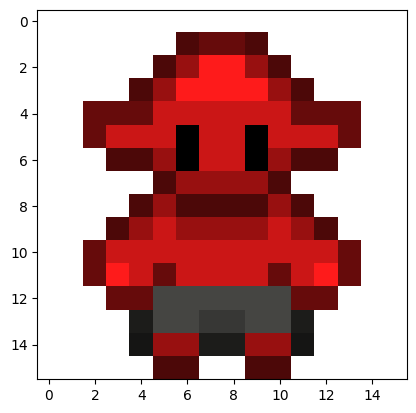

In [55]:
plt.imshow(x0)
plt.show()

이제 `x0`가 확률변수라는 것을 실험해보기 위해 `scipy`에서 제공하는 다변수 정규분포 `multivariate_normal`를 임포트 합니다.

In [56]:
# x0가 확률변수라는 것을 실험해보기 위해 다변수 정규분포를 임포트
from scipy.stats import multivariate_normal

`x0`를 16x16x3=768개 숫자를 가지는 벡터 변수로 보고 방금 준비한 `x0`을 평균으로 하는 정규분포 `q_x0`를 생성합니다.

In [57]:
# 이미지를 768차원 확률 벡터 변수로 만들고
x0_flt = x0.reshape(-1)

# 이 이미지 x0_flt를 평균으로 하고
# 0.1정도되는 적당한 수를 곱해서 공분산을 만들어 정규분포를 정의
# 이 수가 커지면 평균으로 부터 멀리 떨어진 이미지까지 샘플링되고
# 작으면 평균과 거의 비슷한 이미지들만 샘플링됨
q_x0 = multivariate_normal(mean=x0_flt, cov=0.1 * np.eye(len(x0_flt)))

생성된 분포 `q_x0`에서 값 3개를 샘플링해서 화면이 그려봅니다.

In [58]:
# 3개만 샘플링 해서
samples = q_x0.rvs(size=3)
# 크기를 보면 (3,768)
print(samples.shape)

(3, 768)


768차원 벡터 변수 3개가 샘플링 되었고 이를 적당히 모양 조정해서 화면에 그리면 다음처럼 그려집니다.

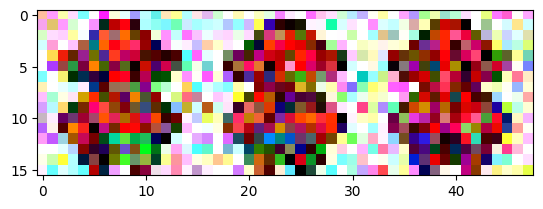

In [59]:
# x0 주변에서 임의로 선택된 샘플들
plt.imshow(samples.reshape(3,16,16,3).transpose(1,0,2,3).reshape(16,-1,3).clip(0,1))
plt.show()

나타나는 그림은 샘플링을 시도할 때마다 조금씩 달라지게 되고 `q_x0`를 만들 때 설정한 분산 `cov`에 곱하는 숫자 0.1을 더 크게 할 수록 점점 더 노이즈가 많은 이미지가 샘플링 될 수 있습니다. `x0` 주변에서 완전히 엉뚱한 노이즈 이미지가 샘플링되는 것이 아니라 평균 이미지를 중심으로 노이즈가 낀 이미지가 샘플링되는 것은 분명히 확인할 수 있습니다.

이미지를 나타내는 변수 $\mathbf{x}_0$가 확률변수라는 점을 실험을 통해 분명히 했으므로 나머지 내용을 계속 이어가도록 합시다.

DDPM의 Fig.2는 완전한 노이즈 $\mathbf{x}_T$로 부터 깨끗한 이미지 $\mathbf{x}_0$가 만들어지는 과정을 그리고 있습니다. 즉, $\mathbf{x}_T, \mathbf{x}_{T-1}, \mathbf{x}_{T-2}, ... , \mathbf{x}_1$이 어떻게 선택되냐에 따라서 $\mathbf{x}_0$가 결정된다는 것이고 DDPM 논문에서 이미지가 생성되는 과정을 이렇게 모델링하는 것입니다. 원인과 결과를 따져보자면 $\mathbf{x}_0$는 결과가 되고 $\mathbf{x}_T, \mathbf{x}_{T-1}, \mathbf{x}_{T-2}, ... , \mathbf{x}_1$들은 $\mathbf{x}_0$라는 결과를 만들어낸 원인이 되는 것입니다.

하지만 오직 $\mathbf{x}_0$만 관찰될 수 있고 어떤 $\mathbf{x}_T$ ~ $\mathbf{x}_1$이 선택되어서 지금 보고 있는 $\mathbf{x}_0$가 결정되었는지 알 수 없습니다. 이렇게 관찰되는 변수observable variable와 관계되어 영향을 미치지만 직접 관찰되지 않는 변수를 잠재 변수latent variable라 합니다.

앞서 알아본것 처럼 $\mathbf{x}_0$의 분포 $q(\mathbf{x}_0)$를 알면 이 분포로 부터 $\mathbf{x}_0$를 샘플링할 수 있습니다. 찾고 싶은 $q(\mathbf{x}_0)$를 신경망 같은 모델로 만들어볼 수 있을 것입니다. 그렇게 신경망 따위로 만든 $\mathbf{x}_0$의 분포를 $ p_\theta(\mathbf{x}_0)$로 쓸 수 있습니다. 이렇게 DDPM에서는 학습으로 만들어가는 분포를 $p()$로 적고 원래 있는 분포 다시 말해 찾고 싶은 분포를 $q()$로 적습니다. $p$ 아래 있는 $\theta$는 모델이 $q(\mathbf{x}_0)$처럼 잘 작동하기 위해 찾아야 하는 파라미터가 됩니다.

$\mathbf{x}_0, \mathbf{x}_1, ... , \mathbf{x}_T$들은 서로 연결joint되 있으므로 이 전체 확률변수들의 분포를 $p_\theta(\mathbf{x}_0, \mathbf{x}_1, ... , \mathbf{x}_T)$ 로 쓸 수 있는데 원문에서는 이를 줄여 $p_\theta(\mathbf{x}_{0:T})$로 쓰고 $\mathbf{x}_{0:T}$를 $\mathbf{x}_0, \mathbf{x}_1, ... , \mathbf{x}_T$들이 모두 결합된 확률변수로 나타냅니다. 최종적으로 관심이 있는 분포는 $\mathbf{x}_0$에 대한 분포 이므로 관심 없는 잠재변수는 주변화 시켜 다음처럼 나타낼 수 있습니다.

$$
p_{\theta}(\mathbf{x}_0) = \int p_\theta (\mathbf{x}_{0:T}) d\mathbf{x}_{1:T}
$$

갑자기 적분 기호가 나와서 머리가 아플 수 있는데 위 식의 의미는 잠재 변수 $\mathbf{x}_{1:T}$를 조건으로 $\mathbf{x}_0$의 평균을 구한 것으로 생각하면 됩니다. 따라서 $p_{\theta}(\mathbf{x}_0)$가 구해진다면 이 분포는 우리에게 잠재 변수를 고려한 평균적인 $\mathbf{x}_0$를 샘플링할 수 있게 해줄 것입니다.

만약 $p_\theta (\mathbf{x}_{0:T})$를 완전히 알고 있고 이 분포를 사용해서 샘플링하게 된다면 완전 노이즈 이미지 $\mathbf{x}_T$와 여러 단계를 거쳐 노이즈가 조금씩 제거된 이미지 $\mathbf{x}_{T-1}, ... \mathbf{x}_1$, 그리고 마지막 깨끗한 이미지 $\mathbf{x}_0$를 모두 한 세트로 뽑을 수 있게 될 것입니다. 그런 샘플링이 가능하다면 다음과 같은 샘플은 뽑힐 가능성이 아주 높을 것입니다.

<img src="https://raw.githubusercontent.com/metamath1/imgs/main/diffusion/diffusion_process_01.png" alt="ddpm figure2" />

<img src="https://raw.githubusercontent.com/metamath1/imgs/main/diffusion/diffusion_process_02.png" alt="ddpm figure2" />

반면 다음 같이 빨간 캐릭터가 살짝 보이다가 갑자기 하얀 캐릭터로 바뀌면서 노이즈가 제거되는 샘플은 뽑힐 가능성은 아주 낮겠죠.

<img src="https://raw.githubusercontent.com/metamath1/imgs/main/diffusion/diffusion_process_03.png" alt="ddpm figure2" />

이렇게 노이즈가 제거 되어 가는 과정에 대한 변수를 한꺼번에 뽑을 수 있는 분포 $p_\theta (\mathbf{x}_{0:T})$를 **리버스 프로세스reverse process**라고 합니다. 이 리버스 프로세스에는 고차원의 확률변수들이 너무 많이 결합되어 있으므로 문제를 간단히 하기 위해 마르코프 가정을 하게 됩니다. 원래는 $\mathbf{x}_{0}$에 잠재 변수 $\mathbf{x}_{1:T}$ 모두가 영향을 미치는 것으로 이야기했지만 모델링 과정에서 마르코프 과정을 가정하고 $\mathbf{x}_{0}$에는 $\mathbf{x}_{1}$만 잠재 변수가 되게 모델링하게 됩니다. 동일하게 $\mathbf{x}_{1}$에는 $\mathbf{x}_{2}$만이 잠재 변수가 되겠네요. 마르코프 가정을 하고 각 시간 단계에 대한 이미지의 분포를 다음처럼 정의합니다.

$$
p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t ) := \mathcal{N} \left(\mathbf{x}_{t-1}; \boldsymbol{\mu}_\theta (\mathbf{x}_t, t), \boldsymbol{\Sigma}_\theta(\mathbf{x}_t, t)\right)
$$

위 정의에서 각 이미지에 대한 분포를 정규분포로 가정했습니다. 위 식의 의미는 노이즈가 조금 더 제거된 $\mathbf{x}_{t-1}$에 대한 분포는 바로 이전 단계인 노이즈가 약간 더 많은 $\mathbf{x}_{t}$를 이용해 계산된 어떤 평균 $\boldsymbol{\mu}_\theta (\mathbf{x}_t, t)$와 분산 $\boldsymbol{\Sigma}_\theta(\mathbf{x}_t, t)$을 파라미터로 하는 정규분포로 정의 한다는 것입니다. 이 때 $\boldsymbol{\mu}_\theta (\mathbf{x}_t, t)$, $\boldsymbol{\Sigma}_\theta(\mathbf{x}_t, t)$같은 것들은 입력 $\mathbf{x}_t$를 보고 네트워크가 추정해야 하는 값들 입니다. 다시말해 노이즈가 많은 $\mathbf{x}_t$를 네트워크의 입력으로 넣으면 네트워크는 그 입력을 이용해서 정규분포로 가정된 노이즈가 약간 더 적은 $\mathbf{x}_{t-1}$의 분포를 평균과 분산을 추정해서 알아내는 것입니다.

마지막 단계인 $\mathbf{x}_T$는 순수한 가우시안 노이즈라고 보면 $p(\mathbf{x}_T) = \mathcal{N}(\mathbf{x}_T; \mathbf{0}, \mathbf{I})$가 되겠고 위 정의와 함께 쓰면 리버스 프로세스 $p_\theta(\mathbf{x}_{0:T})$는 마르코프 가정에 의해 다음처럼 모두 곱해진 형태로 정의될 수 있습니다.

$$
p_\theta(\mathbf{x}_{0:T}) := p(\mathbf{x}_T) \prod^{T}_{t=1}p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t) \tag{1}
$$

마르코프 가정 덕분에 적어도 무시무시한 적분 기호는 사라졌네요. 😁




## 포워드 프로세스

<img src="https://raw.githubusercontent.com/metamath1/imgs/main/diffusion/ddpm-fig2.png" style="width: 100%;" alt="ddpm figure2" border="1px solid black"/>

멀쩡한 이미지에 노이즈가 점점 확산되어 최종적으로 완전히 노이즈 $\mathbf{x}_T$가 되는 과정을 **포워드 프로세스forward process**라고 합니다. 그림에선 오른쪽에서 왼쪽으로 진행되는 과정입니다. 포워드이라고 하면 보통 왼쪽에 오른쪽으로 진행되는 그림을 상상하게 되는데 논문에서는 유독 이를 거꾸로 그렸습니다. $\mathbf{x}$에 대한 인덱스도 0에서 $T$까지가 오른쪽에서 왼쪽으로 진행되도록 그려져서 처음 이 그림을 보면 한동안은 포워드 프로세스가 어느 방향인지 계속 햇갈리게 됩니다. 최종 목적이 노이즈로 부터 이미지를 만들어 가는 과정이므로 논문 저자들은 이렇게 반대로 그려놓는 것이 아마 더 자연스럽다고 생각한것 같습니다.

리버스 프로세스를 알아보면서 잠재 변수 $\mathbf{x}_{1:T}$는 이미지 $\mathbf{x}_0$에 대한 원인이고 $\mathbf{x}_0$는 결과라고 했습니다. 결과를 조건으로 하는 원인의 확률을 사후 확률posterior이라고 합니다. 그럼 사후 확률 분포는 $q(\mathbf{x}_{1:T} \mid \mathbf{x}_0)$로 쓸 수 있습니다. 이 사후 확률을  **포워드 프로세스** 또는 **디퓨전 프로세스diffusion process**라고 합니다. 앞서 이야기한 것처럼 그림에서 오른쪽에서 왼쪽으로 진행되는 과정입니다. 이 확률 분포는 $\mathbf{x}_0$가 주어지면 이 이미지를 생성하기 위해 거쳐가야 하는 모든 잠재변수 $\mathbf{x}_{1:T}$에 대한 분포를 정의하게 됩니다.

리버스 프로세스는 직접 수식으로 계산할 수 없지만 포워드 프로세스는 마르코프 과정을 상정하고 각 과정이 정규분포라고 가정하면 직접 계산할 수 있습니다. 리버스 프로세스 때와 같이 마르코프 가정을 하면 그림에서 나타낸 노이즈가 조금 적은 $\mathbf{x}_{t-1}$을 조건으로 그 다음 노이즈가 조금 더 많은 이미지 $\mathbf{x}_t$에 대한 분포는 다음처럼 정의 할 수 있습니다.

$$
q(\mathbf{x}_t \mid \mathbf{x}_{t-1}) := \mathcal{N}(\mathbf{x}_t ; \sqrt{1-\beta_t} \mathbf{x}_{t-1} , \beta_t \mathbf{I})
$$

이 식에서 $\beta_t$는 각 단계에서 노이즈를 얼마나 추가할 지 결정하게 되는 상수입니다. 이렇게 정의된 개별 분포를 모두 곱해서 잠재 변수에 대한 사후 확률, 포워드 프로세스를 정의 합니다.

$$
q(\mathbf{x}_{1:T} \mid \mathbf{x}_0):= \prod^{T}_{t=1} q(\mathbf{x}_t \mid \mathbf{x}_{t-1}) \tag{2}
$$

앞서 리버스 프로세스에서 노이즈를 제거하는 한 단계 $p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t )$를 정의한 바 있습니다. 노이즈가 더해지는 과정 $q(\mathbf{x}_t \mid \mathbf{x}_{t-1})$로 부터 $q(\mathbf{x}_{t-1} \mid \mathbf{x}_t)$를 바로 알아 낼 수 있으면 $p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t )$를 만들 필요가 없습니다. 하지만 이를 위해 베이즈 정리를 사용한다면 모든 시간 단계에 대한 $q(\mathbf{x}_t)$를 다 알아야 하므로 쉽지 않은 일입니다.

$$
q(\mathbf{x}_{t-1} \mid \mathbf{x}_t) = \frac{q(\mathbf{x}_t \mid \mathbf{x}_{t-1}) q(\mathbf{x}_{t-1})}{q(\mathbf{x}_t)}
$$


그래서 $q(\mathbf{x}_t \mid \mathbf{x}_{t-1})$의 역과정인 $q(\mathbf{x}_{t-1} \mid \mathbf{x}_t)$를 $p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t )$로 대신하고자 하는게 DDPM에서 하고자 하는 것입니다.

그런데 $p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t )$을 잘 만들려면 지도 학습 관점에서 비교 대상인 $q(\mathbf{x}_{t-1} \mid \mathbf{x}_t)$를 알아야 하는데 이 분포는 모른다고 했으니 학습에 사용할 비교 대상이 없습니다. 이 문제를 인식하고 이를 해결하는 과정을 이해하는 것이 DDPM 논문을 이해하는 거의 전부라 할 수 있으니 차차 알아보도록 하겠습니다.

이제 정의된 포워드 프로세스를 실험해보기 위해 $\beta_t$, $T$같은 값들을 정해야 하는데 DDPM 논문에서는 각 설정값을 다음처럼 지정했다고 나와있습니다.

> $T=1000$, $\beta_1 = 10^{-4}$, $\beta_T = 0.02$

논문과 동일하게 `beta()` 함수를 작성합니다.

In [60]:
def beta(t, T=1000):
    # t: 1~T
    # t는 1에서 T까지 이므로 인덱싱할 때는 -1해준다.
    return np.linspace(1.0e-4, 0.02, T)[t-1]

실험에 사용할 샘플 이미지 $\mathbf{x}_0$를 준비합니다. 이때 이미지의 픽셀 값들이 -1, 1사이에 오게 노멀라이즈 합니다.

In [61]:
x0 = (sprites / 255)[10] * 2 - 1
x0.min(), x0.max()

(-1.0, 1.0)

이 이미지의 크기는 (16,16,3)입니다.

In [62]:
x0.shape

(16, 16, 3)

분포 $q(\mathbf{x}_t \mid \mathbf{x}_{t-1})$를 만들어주는 함수 `get_q_xt_given_xtm1()`을 정의합니다. 이 함수는 내부에서 $q(\mathbf{x}_t \mid \mathbf{x}_{t-1})$ 정의에 따라 정규분포를 하나 만들고 그 분포를 반환합니다.

In [63]:
def get_q_xt_given_xtm1(xtm1, t):
    beta_t = beta(t)
    xtm1_flt = xtm1.reshape(-1)

    q = multivariate_normal(
        mean=np.sqrt(1-beta_t)*xtm1_flt,
        cov=beta_t*np.eye(len(xtm1_flt))
    )

    return q

샘플 `x0`를 사용해서 $\mathbf{x}_1$에 대한 분포를 생성합니다.

In [64]:
# t=1을 지정해 원본 이미지 x0에서 1단계 노이즈 상태인 이미지에 대한 분포를 생성
q_x1_given_x0 = get_q_xt_given_xtm1(x0, t=1)

이 분포는 $\sqrt{1-\beta}\mathbf{x}_0$를 평균으로 하는 정규분포이므로 $\mathbf{x}_0$에 대한 밀도 함숫값, 다시말해 이 분포에서 $\mathbf{x}_0$가 존재할 가능성은 크고 일반 노이즈에 대한 가능성은 작아야 합니다. 밀도 함숫값의 로그값을 계산해주는 `logpdf()` 함수로 확인해봅시다.

In [65]:
# x0에 대한 확률 밀도값                  그냥 노이즈에 대한 확률 밀도값
q_x1_given_x0.logpdf( x0.reshape(-1) ), q_x1_given_x0.logpdf( np.random.randn( 16*16*3 ) )

(2831.0183943629117, -6668724.782266297)

예상대로 $\mathbf{x}_0$에 대한 값은 매우 크고 표준 정규분포로 부터 샘플링된 노이즈에 대한 값은 로그값이 매우 작은 음수이므로 거의 0임을 알 수 있습니다. 이제 정의된 분포로부터 $\mathbf{x}_1$ 하나를 샘플링합니다.

In [66]:
x1 = q_x1_given_x0.rvs(size=1)

제대로 작동한다면 `x1`은 `x0`와 거의 차이가 없어야 할 것입니다.

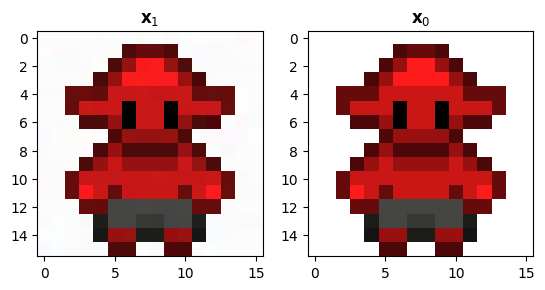

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=2)

x0_ = ((x0 - x0.min()) / (x0.max() - x0.min())).clip(0,1)
x1_ = ((x1 - x1.min()) / (x1.max() - x1.min())).clip(0,1)

ax[0].imshow(x1_.reshape(16,16,3))
ax[0].set_title(r"$\mathbf{x}_1$")

ax[1].imshow(x0_.reshape(16,16,3))
ax[1].set_title(r"$\mathbf{x}_0$")
plt.show()

한 스탭정도 노이즈를 확산시켜서는 아무런 차이가 없는듯 보입니다. 경우에 따라 흰색 배경부분을 자세히 보면 완전 흰색이 아니라 약간 색이 달라진 것을 미세하게 확인할 수 있을 수도 있습니다(아주 약하게 나타나거나 모니터에 따라 확인되지 않을 수 있음). 이제 $T$ 단계까지 한 단계씩 차례로 노이즈를 확산시킵니다. `for`루프로 이를 직접 구현해보면 다음과 같습니다. 확산 단계는 30단계까지로 제한했습니다.

In [68]:
x0.min(), x0.max()

(-1.0, 1.0)

In [69]:
%%time

# 루프 돌면서 x30까지 해보기
xts = [x0.reshape(-1).copy()]
xt = xts[0]
T = 30

for t in range(1, T+1):
    # t-1 단계에서 만들어진 이미지로 부터 분포 q(x_t|x_t-1)을 만든다.
    q_xt_given_xtm1 = get_q_xt_given_xtm1(xt, t)
    # 만들어진 분포에서 샘플링한다.
    xt = q_xt_given_xtm1.rvs(size=1)
    xts.append(xt)

CPU times: user 14.6 s, sys: 6.82 s, total: 21.4 s
Wall time: 11.9 s


30단계만 진행했는데도 시간이 상당히 오래 걸립니다. 분포를 정의하고 그로 부터 샘플링하는 과정을 기술적으로 잘 처리해서 속도를 조금 높일 수 있겠지만 원리적으로 시간이 오래 걸리는 과정이라는 사실은 변함이 없습니다. 노이즈가 확산된 30개 이미지와 원본이미지를 담은 리스트를 넘파이 어레이로 변환합니다.

In [70]:
xts = np.array(xts)
xts.shape

(31, 768)



이제 30단계까지 확산된 노이즈를 가진 이미지를 원본 이미지와 비교해보겠습니다.

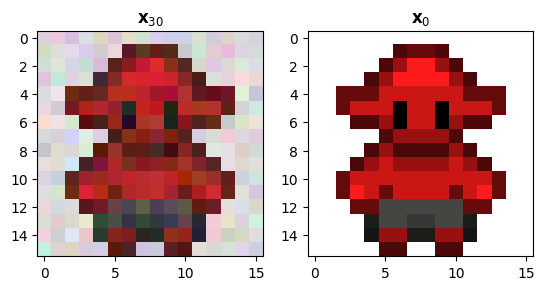

In [71]:
fig, ax = plt.subplots(nrows=1, ncols=2)

x0_ = ((x0 - x0.min()) / (x0.max() - x0.min())).clip(0,1)
xt_ = ((xt - xt.min()) / (xt.max() - xt.min())).clip(0,1)

ax[0].imshow(xt_.reshape(16,16,3))
ax[0].set_title(f"$\mathbf{{x}}_{{{T}}}$")

ax[1].imshow(x0_.reshape(16,16,3))
ax[1].set_title(r"$\mathbf{x}_0$")
plt.show()

확실이 점점 노이즈로 뒤덮히기 시작합니다. DDPM에서는 $T=1000$을 사용하므로 1000단계까지가면 원래 이미지는 완전히 사라지고 노이즈만 있는 이미지가 될 것입니다.



이제 식(2)에 의해 $q(\mathbf{x}_{1:T} \mid \mathbf{x}_0)$를 직접 계산할 수 있습니다. $q(\mathbf{x}_{1:T} \mid \mathbf{x}_0)$를 직접 눈으로 확인해보기 위해 $\mathbf{x}_t$들을 스칼라로 가정하고 $T=2$로 두어 $x_0$, $x_1$, $x_2$로 포워드 프로세스 단계를 제한합니다. 그렇게하면 3차원 그래프로 해당 분포를 그려볼 수 있습니다.

식(2)에 의해 다음과 같으므로

$$
q(x_{1:2} \mid x_0) = q(x_2 \mid x_1) \times q(x_1 \mid x_0)
$$

두 일변수 정규분포를 곱하고 정리하면 다음처럼 $q(x_{1:2} \mid x_0)$를 $x_1$, $x_2$에 대해 계산해주는 함수를 만들 수 있습니다.

In [72]:
def make_q(x0):

    def q(x2, x1):
        return (1 / (2*np.pi)) * np.exp( -(1/2) * ((x2-x1)**2 + (x1-x0)**2) )

    return q

해당 확률분포가 $x_0$에 대해서 어떻게 변하는지 확인하기 위해 그림그리는 모듈을 임포트 합니다.

$x_1$, $x_2$는 -10, 10 정도 범위로 설정하고 $x_0$는 -5, 5까지 범위를 설정해 각 $x_0$에 대해서 $q(x_{1:2} \mid x_0)$를 -10, 10로  정의된 정사각 영역에 대해서 함숫값을 모두 계산합니다. 아울러 이렇게 생성된 $x_0$에 대해서 $q(x_{1:2} \mid x_0)$들이 확률분포로써 타당한지 확인하기 위해 수치적분값이 1이 되는지 확인해봅니다.

In [73]:
from scipy import integrate

# 정의역 정의
x_range = [-10, 10]
y_range = [-10, 10]

x_min, x_max = x_range[0], x_range[1]
y_min, y_max = y_range[0], y_range[1]

xx = np.linspace(x_min, x_max, 150)
yy = np.linspace(y_min, y_max, 150)
X1, X2 = np.meshgrid(xx, yy)
X_grid = np.c_[X1.ravel(), X2.ravel()]

x0s = np.linspace(-5, 5, 21)
Zs = []

for x0_ in x0s:
    q = make_q(x0=x0_)
    Zs.append( q(X_grid[:,0], X_grid[:,1]) )

    # 2차원 수치 적분
    print(f"{integrate.dblquad(q, x_range[0], x_range[1], lambda x: y_range[0], lambda x: y_range[1])[0]:.4f}")

0.9998
0.9999
1.0000
1.0000
1.0000
1.0000
1.0000
1.0000
1.0000
1.0000
1.0000
1.0000
1.0000
1.0000
1.0000
1.0000
1.0000
1.0000
1.0000
0.9999
0.9998


적분값은 모두 거의 1에 가까운 값임을 확인할 수 있습니다. 이제 앞서 `x0s`변수에 범위를 잡아둔 $x_0$에 따른 $x_1$, $x_2$의 분포를 그림으로 그립니다.

In [74]:
layout = go.Layout(
    title='q(x_1:2|x_0)',
    width=600, height=600,
    margin=dict(l=0, r=0, b=0, t=25),
    scene = dict(
        xaxis = dict(title='x2', range=[x_min, x_max],),
        yaxis = dict(title='x1', range=[y_min, y_max],),
        zaxis = dict(title='pdf'),
        aspectratio=dict(x=1, y=1, z=0.5)
    )
)

# Create figure
fig = go.Figure(layout=layout)

# Add traces, one for each slider step
for Z in Zs:
    fig.add_trace(
        go.Surface(
            x=X_grid[:,0].reshape(X1.shape), y=X_grid[:,1].reshape(X1.shape),
            z=Z.reshape(X1.shape),
            showscale=False,  opacity=1.,
            colorscale ='Blues',
            contours=dict(
                x=dict(show=True, highlight=True),
                y=dict(show=True,  highlight=True),
                z=dict(show=True,  highlight=True),
            ), visible=False
        )
    )

fig.data[0].visible = True

# Create and add slider
steps = []

for i in range(0, len(fig.data)):
    step = dict(
        method="update",
        args=[
            {"visible": [False] * (len(fig.data))},
        ],  # layout attribute
        label=f"{x0s[i]:.2f}"
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [
    dict(
        active=0,
        currentvalue={"prefix": "x0: "},
        pad={"l":10, "t": 50, "r":10, "b":10},
        steps=steps
    )
]

fig.update_layout(sliders=sliders)

fig.show()

Output hidden; open in https://colab.research.google.com to view.

위 그림에서 슬라이드를 이동시키면 확률분포가 변하는 것을 확인할 수 있습니다. 여기서 슬라이드로 조정하는 $x_0$는 노이즈가 없는 깨끗한 이미지로 생각할 수 있습니다. 즉 슬라이드의 이동으로 깨끗한 이미지가 변하면 이와 연결된 잠재 변수들의 결합 분포가 변하는 것을 눈으로 확인 해볼 수 있는 것입니다. 당연하겠지만 잠재 변수들은 $x_0$ 근처에 분포하게 됩니다.

이 시각화를 통해서 이미지 $\mathbf{x}_0$와 노이즈가 포함된 이미지 $\mathbf{x}_1, ..., \mathbf{x}_T$에 대한 관계가 조금 더 명확히 이해 되었으면 좋겠습니다.

이제 $q(\mathbf{x}_{1:T} \mid \mathbf{x}_0)$가 무엇을 의미하는지 잘 이해했으므로 이미지 변수에 대해서 이 분포를 직접 계산하는 함수를 만들어 봅시다.

다음 함수 `get_q_x1T_given_x0()`는 루프를 돌면서 식(2)를 직접 계산하는 함수 `q()`를 리턴합니다. 이 때 확률 밀도 함숫값은 매우 큰 값이 되므로 이를 곱하면 오버플로가 생기게 됩니다. 이를 방지하기 위해 로그 확률 밀도값을 더하는 방식을 사용합니다.

In [75]:
def get_q_x1T_given_x0(x0, T=T, x0_shape=(16,16,3)):
    # T개의 확률변수를 만든다.
    def q(x1T):
        # x1T: T*16*16*3
        x1_T = x1T.reshape(T, np.prod(x0_shape)) # (T, 16*16*3)
        x0_T = np.concatenate((x0.reshape(1,-1), x1_T), axis=0) # (T+1, 16*16*3)

        density = 0.0
        for t in range(1, T+1):
            q_xt_given_xtm1 = get_q_xt_given_xtm1(x0_T[t-1], t)
            density += q_xt_given_xtm1.logpdf(x0_T[t])

        return density

    return q


 `x0`를 조건으로 입력하여 $q(\mathbf{x}_{1:30} \mid \mathbf{x}_0)$ 분포를  생성합니다.

In [76]:
xts[30].min(), xts[30].max()

(-1.235078829838733, 1.3871022182551616)

In [77]:
q_x130_given_x0 = get_q_x1T_given_x0(x0, T=T)

$q(\mathbf{x}_1 \mid \mathbf{x}_{0})$에 대해서 $\mathbf{x}_0$와 표준 정규분포로 부터 샘플링된 노이즈를 입력하여 각 샘플에 대한 가능성을 `logpdf()`로 직접 계산해본 실험을 여기서 다시 해보겠습니다.

$q(\mathbf{x}_{1:30} \mid \mathbf{x}_0)$에 대해서 표준 정규분포로 부터 샘플링된 `(30, 16, 16, 3)` 크기를 가지는 노이즈를 입력합니다.

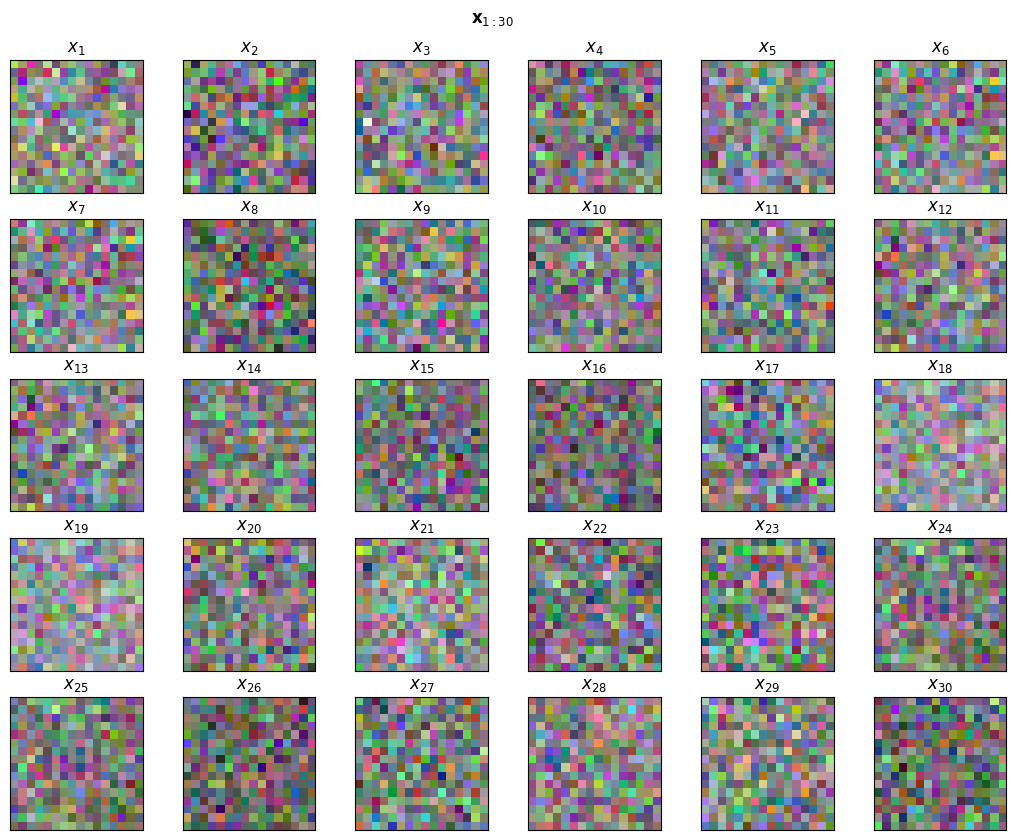

In [78]:
x_random = np.random.randn( (T+1), 16, 16, 3 )

fig, ax = plt.subplots(figsize=(13,10), nrows=5, ncols=6)

for i in range(5):
    for j in range(6):
        xt = x_random[i*5+j+1]
        xt = ((xt - xt.min()) / (xt.max() - xt.min())).clip(0,1)
        ax[i][j].imshow(xt.reshape(16,16,3))
        title = f"$x_{{{i*6+j+1}}}$"
        ax[i][j].set_title(title)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

fig.suptitle(r"$\mathbf{x}_{1:30}$", y=0.93)
plt.show()

위 그림이 $\mathbf{x}_{1:30}$을 나타냅니다. 이 샘플은 $q(\mathbf{x}_{1:30} \mid \mathbf{x}_0)$에서 존재할 가능성이 매우 작을 것입니다.

In [79]:
q_x130_given_x0( x_random[1:].reshape(-1) )

-77199772.13549806

거의 0이 됩니다. 반면 조금전 $\mathbf{x}_0$로부터 30단계까지 노이즈를 확산하면서 얻은 이미지 30장 세트로 구성된 $\mathbf{x}_{1:30}$는 분포 $q(\mathbf{x}_{1:30} \mid \mathbf{x}_0)$상에서 큰 가능성을 가질 것입니다. 이 샘플이 `xts`에 저장되어 있으므로 실험을 해볼 수 있습니다.

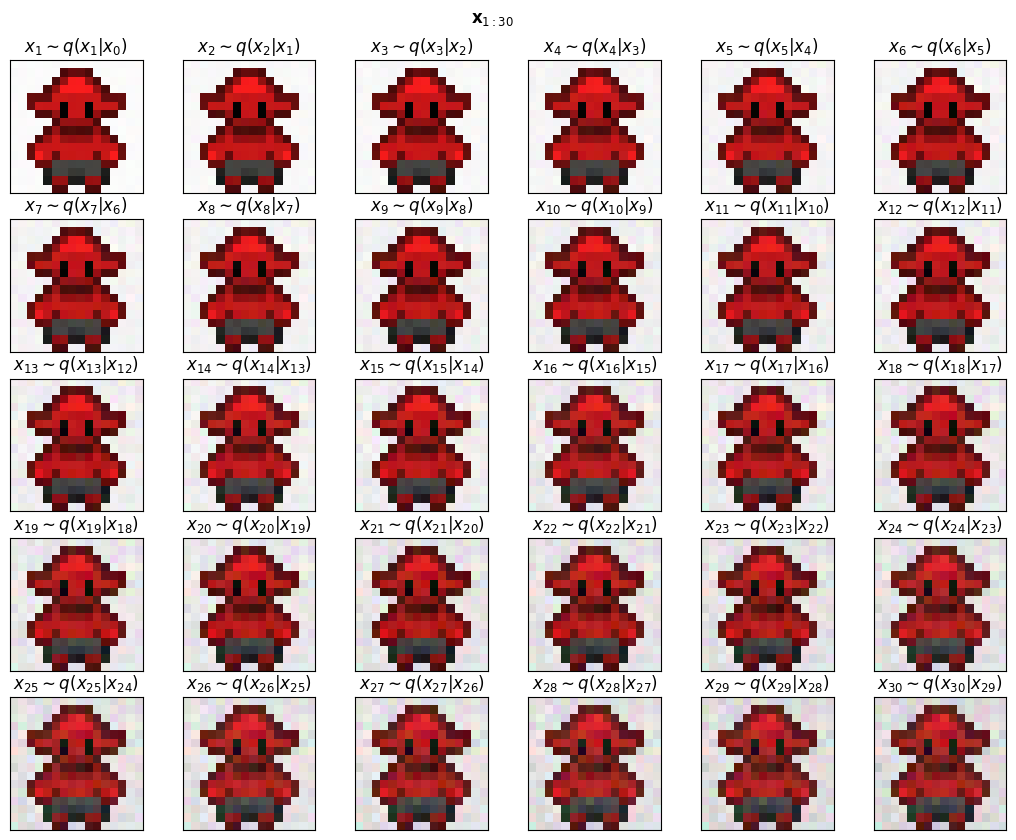

In [80]:
fig, ax = plt.subplots(figsize=(13,10), nrows=5, ncols=6)

for i in range(5):
    for j in range(6):
        xt = xts[i*5+j+1]
        xt = ((xt - xt.min()) / (xt.max() - xt.min())).clip(0,1)
        ax[i][j].imshow(xt.reshape(16,16,3))
        title = f"$x_{{{i*6+j+1}}} \sim q(x_{{{i*6+j+1}}} | x_{{{i*6+j}}})$"
        ax[i][j].set_title(title)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

fig.suptitle(r"$\mathbf{x}_{1:30}$", y=0.93)
plt.show()

In [81]:
q_x130_given_x0( xts[1:].reshape(-1) )

59038.57863825033

예상처럼 꽤 큰 값을 돌려줍니다. 만약 이 $q(\mathbf{x}_{1:30} \mid \mathbf{x}_0)$로 부터 정밀하게 샘플링 할 수 있다면 위 그림과 비슷한 하지만 조금씩 다른 노이즈가 확산된 이미지 세트를 얻을 수 있을 것입니다.

마지막으로 $\mathbf{x}_{15}$를 노이즈 확산의 시작 이미지인 $\mathbf{x}_0$로 설정하고 30단계 노이즈를 확산하면 방금 실험한 $\mathbf{x}_{1:30}$과는 노이즈 정도가 사뭇 다른 이미지들이 얻어질텐데 이 이미지들의 $q(\mathbf{x}_{1:30} \mid \mathbf{x}_0)$에서 가능성은 어떻게 될지 실험해보겠습니다.

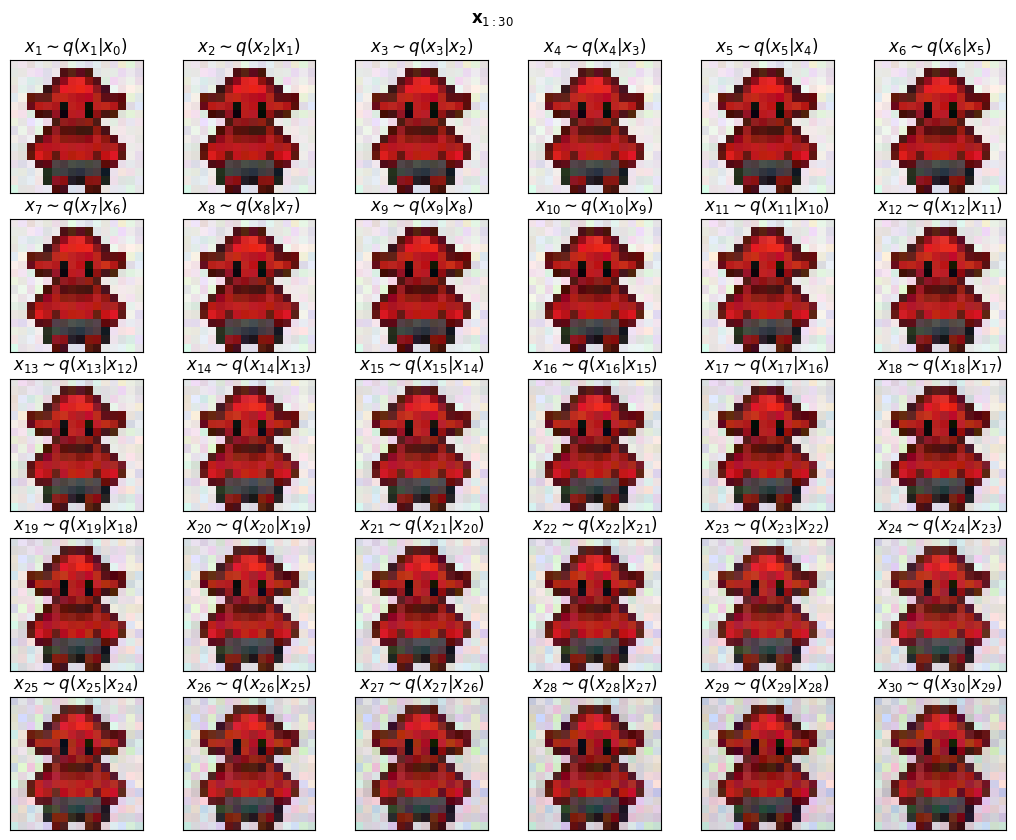

CPU times: user 20.1 s, sys: 9.9 s, total: 30 s
Wall time: 17.1 s


44190.52832950361

In [82]:
%%time

# xts[15]에 저장된 x_15를 시작이미지 y0로 두고 y1 ~ y30까지 생성
yts = [xts[15].reshape(-1)]
yt = yts[0]

for t in range(1, T+1):
    # t-1 단계에서 만들어진 이미지로 부터 분포 q(x_t|x_t-1)을 만든다.
    q_xt_given_xtm1 = get_q_xt_given_xtm1(yt, t)
    # 만들어진 분포에서 샘플링한다.
    yt = q_xt_given_xtm1.rvs(size=1)
    yts.append(yt)

yts = np.array(yts)
yts.shape

fig, ax = plt.subplots(figsize=(13,10), nrows=5, ncols=6)

for i in range(5):
    for j in range(6):
        xt = yts[i*6+j+1]
        xt = ((xt - xt.min()) / (xt.max() - xt.min())).clip(0,1)
        ax[i][j].imshow(xt.reshape(16,16,3))
        title = f"$x_{{{i*6+j+1}}} \sim q(x_{{{i*6+j+1}}} | x_{{{i*6+j}}})$"
        ax[i][j].set_title(title)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

fig.suptitle(r"$\mathbf{x}_{1:30}$", y=0.93)
plt.show()

q_x130_given_x0( yts[1:].reshape(-1) )

그려진 샘플을 확인해보세요. 이번 샘플은 처음부터 노이즈가 존재합니다. 이렇게 확산된 노이즈 정도가 다르기 때문에 확률분포에서 존재할 가능성은 조금 떨어진것을 알 수 있습니다.

다음에 지금까지 야이기한 리버스 프로세스와 포워드 프로세스를 다시 정리했습니다.

- 리버스 프로세스와 포워드 프로세스
$$
\begin{aligned}
&p_\theta(\mathbf{x}_{0:T}) := p(\mathbf{x}_T) \prod^{T}_{t=1}p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t), \qquad &p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t ) := \mathcal{N} \left(\mathbf{x}_{t-1}; \boldsymbol{\mu}_\theta (\mathbf{x}_t, t), \boldsymbol{\Sigma}_\theta(\mathbf{x}_t, t)\right), \quad p(\mathbf{x}_T) = \mathcal{N}(\mathbf{x}_T; \mathbf{0}, \mathbf{I})  
\\
&q(\mathbf{x}_{1:T} \mid \mathbf{x}_0):= \prod^{T}_{t=1} q(\mathbf{x}_t \mid \mathbf{x}_{t-1}), \qquad &q(\mathbf{x}_t \mid \mathbf{x}_{t-1}) := \mathcal{N}(\mathbf{x}_t ; \sqrt{1-\beta_t} \mathbf{x}_{t-1} , \beta_t \mathbf{I})
\end{aligned}
$$

리버스 프로세스에만 파라미터가 있고 포워드 프로세스에는 없는 점을 유념해야 합니다.

## 손실 함수

앞에서 정의한 리버스 프로세스에서 잠재 변수를 주변화시켜 $p_\theta (\mathbf{x}_0)$를 얻을 수 있다는 점을 이야기했습니다.

$$
p_{\theta}(\mathbf{x}_0) = \int p_\theta (\mathbf{x}_{0:T}) d\mathbf{x}_{1:T}
$$

이렇게 얻은 $p_\theta (\mathbf{x}_0)$는 $\theta$에 대한 $\mathbf{x}_0$의 가능도 함수입니다. 파라미터 $\theta$를 조정해서 이 가능도를 최대화 시키는 것을 최대 가능도 추정Maximum Likelihood Estimation이라 하고 많은 모델들이 이 MLE 과정으로 학습하게 됩니다. 이처럼 가능도 함수를 최대화 시키는 $\theta$를 최적화 알고리즘을 통해 찾는 것이 학습의 목표인데 최적화는 보통 함수의 최소화를 수행하므로 $-1$을 곱해서 마이너스 로그 가능도로 만듭니다. 또 가능도 함수는 곱하기에 의해 정의되는 경우가 많기 때문에 가능도 함수를 직접 다루기 보다 로그를 씌워서 로그 가능도 함수를 다루는 경우가 많습니다 (실제로 앞서 정의한 $p_\theta (\mathbf{x}_{0:T})$도 많은 곱하기로 이뤄져 있음을 알 수 있습니다).

$$
- \log p_{\theta}(\mathbf{x}_0) = - \log \left( \int p_\theta (\mathbf{x}_{0:T})   d\mathbf{x}_{1:T}\right)
$$

우변은 잠재 변수에 대한 적분입니다. 이 적분을 앞서 알아본 잠재 변수의 $\mathbf{x}_0$에 대한 조건부 분포 $q(\mathbf{x}_{1:T} \mid \mathbf{x}_0)$에 대한 기댓값으로 바꾸기 위해 우변을 다음처럼 변형합니다.


$$
\begin{aligned}
- \log p_{\theta}(\mathbf{x}_0) &= - \log \left( \int p_\theta (\mathbf{x}_{0:T})   d\mathbf{x}_{1:T}\right) \\[10pt]
&= - \log \left( \int q(\mathbf{x}_{1:T} \mid \mathbf{x}_0) \frac{p_\theta (\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T} \mid \mathbf{x}_0)}   d\mathbf{x}_{1:T}\right) \\[10pt]
&= - \log \left( \mathbb{E}_{q(\mathbf{x}_{1:T} \mid \mathbf{x}_0)} \left[ \frac{p_\theta (\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T} \mid \mathbf{x}_0)}  \right] \right)
\end{aligned}
$$

위 식은 $\mathbf{x}_0$에 대한 가능도는 $\frac{p_\theta (\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T} \mid \mathbf{x}_0)}$를 $\mathbf{x}_0$를 조건으로 하는 모든 존재 가능한 잠재 변수 $\mathbf{x}_{1:T} \mid \mathbf{x}_0$에 대해서 평균을 취한것과 같다는 것을 이야기 합니다.

여기서 볼록함수convex function에서 성립하는 젠슨 부등식Jensen's Inequality를 적용하는데 젠슨 부등식을 다음과 같습니다.

$$
f(\mathbb{E}[x]) \le \mathbb{E}[f(x)]
$$

유도하고 있는 식에서 $ -\log $는 볼록함수이므로 젠슨 부등식이 성립하고 이를 적용하면 다음과 같습니다.


$$
\begin{aligned}
- \log p_{\theta}(\mathbf{x}_0) &= - \log \left( \int p_\theta (\mathbf{x}_{0:T})   d\mathbf{x}_{1:T}\right) \\[10pt]
&= - \log \left( \int q(\mathbf{x}_{1:T} \mid \mathbf{x}_0) \frac{p_\theta (\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T} \mid \mathbf{x}_0)}   d\mathbf{x}_{1:T}\right) \\[10pt]
&= - \log \left( \mathbb{E}_{q(\mathbf{x}_{1:T} \mid \mathbf{x}_0)} \left[ \frac{p_\theta (\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T} \mid \mathbf{x}_0)}  \right] \right) \\[10pt]
&\le \mathbb{E}_{q(\mathbf{x}_{1:T} \mid \mathbf{x}_0)}\left[ -\log \left( \frac{p_\theta (\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T} \mid \mathbf{x}_0)}\right) \right]
\end{aligned}
$$

방금 유도한 식은 마이너스 로그 가능도 함수의 상한을 알려 줍니다. 그 상한은 잠재 변수에 대한 평균이라는 것도 이해했습니다. 이 상한을 최소화하면 마이너스 로그 가능도도 자연스럽게 작아질 수 밖에 없습니다.

이제 좌변을 모든 $\mathbf{x}_0$에 대한 평균으로 만듭니다. 그럼 다음과 같은 과정을 통해 DDPM 식(3)의 부등식 부분이 유도 됩니다.

$$
\begin{aligned}
\mathbb{E}_{q(\mathbf{x}_0)} \left[ - \log p_{\theta}(\mathbf{x}_0) \right] &= \mathbb{E}_{q(\mathbf{x}_0)} \left[- \log \left( \int p_\theta (\mathbf{x}_{0:T})   d\mathbf{x}_{1:T}\right) \right] \\[10pt]
&= \mathbb{E}_{q(\mathbf{x}_0)} \left[ - \log \left( \int q(\mathbf{x}_{1:T} \mid \mathbf{x}_0) \frac{p_\theta (\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T} \mid \mathbf{x}_0)}   d\mathbf{x}_{1:T}\right) \right] \\[10pt]
&= \mathbb{E}_{q(\mathbf{x}_0)} \left[ - \log \left( \mathbb{E}_{q(\mathbf{x}_{1:T} \mid \mathbf{x}_0)} \left[ \frac{p_\theta (\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T} \mid \mathbf{x}_0)}  \right] \right) \right] \\[10pt]
&\le \mathbb{E}_{q(\mathbf{x}_0)} \left[ \mathbb{E}_{q(\mathbf{x}_{1:T} \mid \mathbf{x}_0)}\left[ -\log \left( \frac{p_\theta (\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T} \mid \mathbf{x}_0)}\right) \right] \right] \\[10pt]
&= \mathbb{E}_{q(\mathbf{x}_{0:T})} \left[ -\log \left( \frac{p_\theta (\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T} \mid \mathbf{x}_0)}\right) \right]
\end{aligned}
$$

마지막 등식은 다음에 제시된 [Law of total expectation](https://en.wikipedia.org/wiki/Law_of_total_expectation) $\mathbb{E}[X] = \mathbb{E}\left[\mathbb{E}[X \mid Y]\right]$으로 성립합니다.

$$
\begin{aligned}
\mathbb{E}_{q(y)} \left[ \mathbb{E}_{q(x \mid y)} \left[ f(x,y) \right] \right] &= \int_{y} q(y) \int_{x} q(x \mid y) f(x, y) dx dy\\[5pt]
&= \int_y \int_x q(x \mid y) q(y) f(x,y) dx dy \\[5pt]
&= \int_y \int_x q(x, y) f(x,y) dx dy \\[5pt]
&= \mathbb{E}_{q(x,y)} [f(x,y)]
\end{aligned}
$$

정리하면 다음처럼 됩니다.

$$
\mathbb{E}_{q(\mathbf{x}_0)} \left[ - \log p_{\theta}(\mathbf{x}_0) \right] \le \mathbb{E}_{q(\mathbf{x}_{0:T})} \left[ -\log \left( \frac{p_\theta (\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T} \mid \mathbf{x}_0)}\right) \right] \tag{3*}
$$

식(3*)는 깨끗한 이미지 $\mathbf{x}_0$의 $\theta$에 대한 마이너스 로그 가능도는 우변보다 클 수 없다는 것을 나타냅니다. 여기서 우변을 Variational Bound라고 합니다. 왜 variational 이란 단어를 쓰냐면 이 상한은 잠재 변수의 분포로 제안된 함수 $q(\mathbf{x}_{1:T}\mid \mathbf{x}_0)$에 따라 달라지기 때문입니다.

지금까지 힘들게 겨우 식(3)의 앞 부분을 유도해봤는데 왜 이런 짓을 하고 있는지 이해하는것이 식을 구체적으로 유도하는 것 보다 더 중요할 것입니다. 이 과정을 조금 살펴보도록 하겠습니다.





데이터 $\mathbf{x}_0$에 대한 로그 가능도는 다음처럼 분해될 수 있습니다.

$$
\log p_\theta(\mathbf{x}_0) = \mathbb{E}_{q(\mathbf{x}_{1:T})}\left[ \log \frac{p_\theta(\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T})} \right] + \left( - \mathbb{E}_{q(\mathbf{x}_{1:T})} \left[ \log \frac{p_\theta(\mathbf{x}_{1:T}\mid\mathbf{x}_{0})}{q(\mathbf{x}_{1:T})} \right] \right)
$$

위 분해가 어떻게 가능한지 조금 더 자세히 알고 싶은 독자는 EM 알고리즘에 대해서 정리한 [A Step by Step Introduction to EM Algorithm](https://metamath1.github.io/blog/posts/em/em_algorithm.html)를 참고하시면 좋겠습니다. 좀 긴 분량이 부담이 될 수 있지만 EM 알고리즘에 대해 국내서 가장 자세하고 친철히 설명한 문서라 할 수 있겠습니다.😁

어쨌거나 이렇게 분해된 우변의 첫 번째 항을 Variational Low Bound 또는 Evidence Lower Bound(앞으로 ELBO로 표기)라고 하고 두 번째 항을 KD Divergence라고 합니다.(앞으로 $D_{KL}$로 표기) 이 $D_{KL}$은 두 확률분포의 차이를 측정하는 값으로 해석됩니다. 이 식에서 $D_{KL}$ 항은 $p_\theta(\mathbf{x}_{1:T}\mid\mathbf{x}_0)$와 $q(\mathbf{x}_{1:T})$의 차이를 나타내는 값이 됩니다. 그리고 또 중요한 성질은 항상 0과 같거나 큰 값을 가지게 되고 그렇기 때문에 첫 번째 항이 가능도의 하한이 되게 됩니다. $D_{KL}$을 고려하지 않으면 다음처럼 쓸 수 있습니다.

$$
\log p_\theta(\mathbf{x}_0) \ge \mathbb{E}_{q(\mathbf{x}_{1:T})}\left[ \log \frac{p_\theta(\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T})} \right]  
$$

여기서 우변에 $q(\mathbf{x}_{1:T})$는 잠재변수 $\mathbf{x}_{1:T}$의 분포에 대해서 알지 못하므로 임의로 제안된 분포입니다. 잠재변수에 대한 분포를 어떤 분포로 제안을 해도 위 식이 성립함을 의미합니다. 이 식과 유도된 식 (3*)을 비교하면

$$
\begin{aligned}
\mathbb{E}_{q(\mathbf{x}_0)} \left[ - \log p_{\theta}(\mathbf{x}_0) \right] &\le \mathbb{E}_{q(\mathbf{x}_{0:T})} \left[ -\log \left( \frac{p_\theta (\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T} \mid \mathbf{x}_0)}\right) \right]\\[10pt]
\log p_\theta(\mathbf{x}_0) &\ge \mathbb{E}_{q(\mathbf{x}_{1:T})}\left[ \log \frac{p_\theta(\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T})} \right]  
\end{aligned}
$$

가 되는데 마이너스가 곱해져서 부등호의 방향이 반대인 것과 양변에 확률변수 $\mathbf{x}_0$에 대한 기댓값 연산이 적용된 것이 차이입니다. 첫번째 식의 우변은 마이너스 로그 가능도 평균의 상한이 되고 두번째 식의 우변은 로그 가능도의 하한이 됩니다. 여기서 양변의 차이를 $D_{KL}$가 채우게 되는 것으로

$$
\log p_\theta(\mathbf{x}_0) = \mathbb{E}_{q(\mathbf{x}_{1:T})}\left[ \log \frac{p_\theta(\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T})} \right]  + D_{KL}
$$

처럼 되는데 로그 가능도의 분해식에서 $q(\mathbf{x}_{1:T})$를 $q(\mathbf{x}_{1:T}\mid\mathbf{x}_{0})$로 제안하면


$$
\log p_\theta(\mathbf{x}_0) = \mathbb{E}_{q(\mathbf{x}_{1:T} \mid \mathbf{x}_0)}\left[ \log \frac{p_\theta(\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T}\mid \mathbf{x}_0)} \right] + D_{KL}
$$

이 됩니다. $D_{KL}$을 무시하고 양변에 $\mathbb{E}_{q(\mathbf{x}_0)}[\cdot]$를 적용하면

$$
\mathbb{E}_{q(\mathbf{x}_0)} \left[ \log p_\theta(\mathbf{x}_0)\right] \ge \mathbb{E}_{q(\mathbf{x}_{0:T})}\left[ \log \frac{p_\theta(\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T}\mid \mathbf{x}_0)} \right]
$$

이 되고 모양이 식(3*)와 부등호 방향만 빼고 동일해졌습니다.

이제 우변을 $\theta$에 대해 최대화 시켜 값을 크게 하면 우변은 좌변의 하한이었으므로 좌변은 최대화로 커진 우변보다 항상 조금 더 커지게 되고 그 차이가 다시 0보다 큰 $D_{KL}$로 나타내게 됩니다.

식(3\*)대해서도 동일한 논리가 적용되는데 다른점은 하한이 상한으로 바뀌어 있기 때문에 우변을 최소화 하면 좌변은 항상 우변보다 더 작아지게 되는 것입니다. 때문에 식(3\*)의 우변을 목적함수로 사용할 수 있게 됩니다.



이제 유도된 부등식의 우변항을 $\theta$에 대해서 최적화하는 것이 목적이라는 것을 잘 이해 했으므로 $\theta$와 관련있는 항과 관련없는 항으로 분리하도록 합니다. 우변항 [ ] 안쪽 부분을 다음 과정으로 식을 전개할 수 있습니다.

$$
\begin{aligned}
-\log \left( \frac{p_\theta(\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T} \mid \mathbf{x}_{0})} \right) &= - \log \left( \frac{p(\mathbf{x}_T) \displaystyle\prod_{t=1}^{T} p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t)}{\displaystyle\prod_{t=1}^T q(\mathbf{x}_t \mid \mathbf{x}_{t-1})} \right) \\[10pt]
&=- \log \left( p(\mathbf{x}_T) \cdot \frac{\displaystyle\prod_{t=1}^{T} p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t)}{\displaystyle\prod_{t=1}^T q(\mathbf{x}_t \mid \mathbf{x}_{t-1})} \right) \\[10pt]
&= - \log p(\mathbf{x}_T) - \log \prod_{t=1}^T \frac{p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t)}{q(\mathbf{x}_t \mid \mathbf{x}_{t-1})} \\[10pt]
&= - \log p(\mathbf{x}_T) - \sum_{t=1}^T \log  \frac{p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t)}{q(\mathbf{x}_t \mid \mathbf{x}_{t-1})}
\end{aligned}
$$

전개된 부분을 다시 원식에 적용하면 식(3)이 완성됩니다. 최종적으로 가장 오른쪽에 있는 항을 목적함수 $L$로 정의합니다.

$$
\mathbb{E}_{q(\mathbf{x}_0)} \left[ - \log p_{\theta}(\mathbf{x}_0) \right] \le \mathbb{E}_{q(\mathbf{x}_{0:T})} \left[ -\log \left( \frac{p_\theta (\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T} \mid \mathbf{x}_0)}\right) \right] = \mathbb{E}_{q(\mathbf{x}_{0:T})} \left[  - \log p(\mathbf{x}_T) - \sum_{t=1}^T \log  \frac{p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t)}{q(\mathbf{x}_t \mid \mathbf{x}_{t-1})} \right] := L \tag{3}
$$


식(3)이 목적함수라면 네트워크를 학습시키는데 사용할 수 있다는 말인데 어떻게 사용할 수 있을까요? 식이 너무 복잡해서 뭐가 네트워크의 출력인지 뭐가 타겟인지 지도학습의 손실인지 비지도 학습의 손실인지 분명하게 잘 이해가 안됩니다.

식(3)의 의미를 이해해보기 위해 간단한 실험을 해보도록 하겠습니다. 계산해야 하는 $p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t )$와 $q(\mathbf{x}_t \mid \mathbf{x}_{t-1})$들은 잠재변수가 결합된 형태가 아니라 특정 시간 단계에서 한 단계 이전 또는 이후의 잠재변수에 대한 조건을 가지는 형태로 바뀌었습니다. 따라서 이전에 정의한 다음 두 식으로 부터 값을 계산할 수 있습니다.




$$
p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t ) := \mathcal{N} \left(\mathbf{x}_{t-1}; \boldsymbol{\mu}_\theta (\mathbf{x}_t, t), \boldsymbol{\Sigma}_\theta(\mathbf{x}_t, t)\right)
$$


$$
q(\mathbf{x}_t \mid \mathbf{x}_{t-1}) := \mathcal{N}(\mathbf{x}_t ; \sqrt{1-\beta_t} \mathbf{x}_{t-1} , \beta_t \mathbf{I})
$$

전술했듯이는 $\boldsymbol{\mu}_\theta (\mathbf{x}_t, t)$, $\boldsymbol{\Sigma}_\theta(\mathbf{x}_t, t)$는 네트워크가 출력하는 리버스 프로세스 한 단계에 대한 분포의 평균과 표준편차인데 여기서 실험을 간단히 하기 위해 $\boldsymbol{\Sigma}_\theta(\mathbf{x}_t, t) = \beta_t \mathbf{I}$로 가정하겠습니다.

우선 적당한 $\mathbf{x}_0$에 대해서 1단계에서 $T$ 단계까지 노이즈가 더해진 이미지를 준비합니다. $T=20$으로 두도록 하겠습니다.

In [83]:
x0.min(), x0.max()

(-1.0, 1.0)

In [84]:
%%time

xts = [x0.reshape(-1)]
xt = xts[0]

T = 20
L = xts[0].shape[0]

for t in range(1, T+1):
    # t-1 단계에서 만들어진 이미지로 부터 분포 q(x_t|x_t-1)을 만든다.
    q_xt_given_xtm1 = get_q_xt_given_xtm1(xt, t)

    # 만들어진 분포에서 샘플링한다.
    xt = q_xt_given_xtm1.rvs(size=1)
    xts.append(xt)


CPU times: user 9.74 s, sys: 4.18 s, total: 13.9 s
Wall time: 8.09 s


그리고 현재 가진 네트워크가 잘 학습이 되어 있어서 $\mathbf{x}_{20}$을 입력하면 $\mathbf{x}_{19}$와 매우 유사한 이미지를 출력한다고 하겠습니다. 이를 그림으로 표현하면 다음처럼 표현할 수 있습니다. 그림을 통해 현재 상황을 직관적으로 이해하도록 합시다.

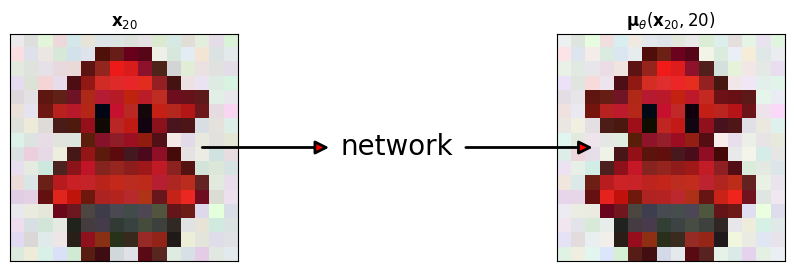

In [85]:
# 샘플1에 대해서 x20을 입력했을 때 네트워크가 평균 x19를 출력했다고 가정
x19_flt = xts[-2].copy()

# x19에 약간의 노이즈를 더해 네트워크의 출력을 시뮬레이션합니다.
x19_flt += 0.001 * np.random.randn(L)
x19 = ((x19_flt - x19_flt.min()) / (x19_flt.max() - x19_flt.min())).clip(0,1)

x20_flt = xts[-1].copy()
x20 = ((x20_flt - x20_flt.min()) / (x20_flt.max() - x20_flt.min())).clip(0,1)

fig, ax = plt.subplots(figsize=(10,3), nrows=1, ncols=3)

ax[0].imshow(x20.reshape(16,16,3))
ax[0].set_title(f"$\mathbf{{x}}_{{{T}}}$")
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].text(0.25, 0.47, 'network', fontsize=20)
con = ConnectionPatch(
    xyA=(13, 7.5), coordsA=ax[0].transData,
    xyB=(0.2, 0.5), coordsB=ax[1].transData,
    arrowstyle="-|>", mutation_scale=20,
    color='k', fc='red', lw=2)
fig.add_artist(con)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_frame_on(False)
con = ConnectionPatch(
    xyA=(0.8, 0.5), coordsA=ax[1].transData,
    xyB=(2, 7.5), coordsB=ax[2].transData,
    arrowstyle="-|>", mutation_scale=20,
    color='k', fc='red', lw=2)
fig.add_artist(con)


ax[2].imshow(x19.reshape(16,16,3))
ax[2].set_title(f"$\mathbf{{\mu}}_\\theta(\mathbf{{x}}_{{{T}}},{T})$")
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()

이제 가상의 네트워크 출력을 평균으로 하는 정규분포를 정의합니다. 이것이 $p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t )$에 해당합니다. $q(\mathbf{x}_t \mid \mathbf{x}_{t-1})$는 위쪽 루프를 실행할 때 이미 마지막에 만들어졌습니다. 준비된 재료를 사용해 식(3)을 계산합니다.

$$
L=\mathbb{E}_{q(\mathbf{x}_{0:T})} \left[  - \log p(\mathbf{x}_T) - \sum_{t=1}^T \log  \frac{p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t)}{q(\mathbf{x}_t \mid \mathbf{x}_{t-1})} \right]
$$

이때 편의상 $\sum_{t=1}^T$ 부분을 모두 계산하지 않고 $T=20$에 해당하는 항 하나만 계산합니다. 또 $- \log p(\mathbf{x}_T) $ 부분도 $\theta$와 무관한 부분이므로 계산하지 않습니다.

In [86]:
# 네트워크의 출력을 평균으로 p(x_{t-1}| x_t)를 정의
p_xtm1_given_xt = multivariate_normal(mean=x19_flt, cov=beta(20)*np.eye(L))

# 손실함수 값을 T=20에 대해서만 계산
- (p_xtm1_given_xt.logpdf(x19_flt) - q_xt_given_xtm1.logpdf(x20_flt))

-393.26033378331476

샘플 $\mathbf{x}_0$ 하나와 연관된 특정 잠재변수 $\mathbf{x}_{1:T}$에 대해서 가상으로 손실함수 값을 계산했습니다.

이번에는 네트워크가 잘 학습되지 않아 $\mathbf{x}_{20}$을 입력하면 엉뚱한 노이즈를 출력한다고 가정해보겠습니다. 다음 그림과 같은 상황입니다.

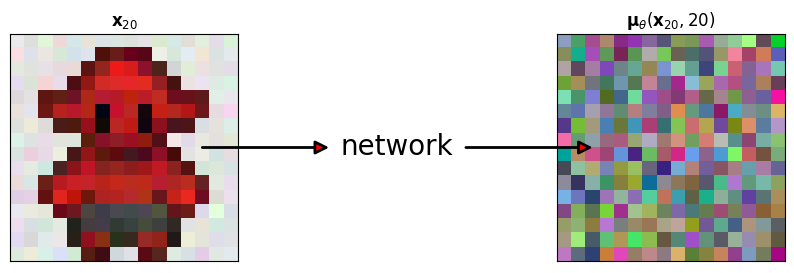

In [87]:
fig, ax = plt.subplots(figsize=(10,3), nrows=1, ncols=3)

ax[0].imshow(x20.reshape(16,16,3))
ax[0].set_title(f"$\mathbf{{x}}_{{{T}}}$")
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].text(0.25, 0.47, 'network', fontsize=20)
con = ConnectionPatch(
    xyA=(13, 7.5), coordsA=ax[0].transData,
    xyB=(0.2, 0.5), coordsB=ax[1].transData,
    arrowstyle="-|>", mutation_scale=20,
    color='k', fc='red', lw=2)
fig.add_artist(con)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_frame_on(False)
con = ConnectionPatch(
    xyA=(0.8, 0.5), coordsA=ax[1].transData,
    xyB=(2, 7.5), coordsB=ax[2].transData,
    arrowstyle="-|>", mutation_scale=20,
    color='k', fc='red', lw=2)
fig.add_artist(con)

noise = np.random.randn(L)
noise = ((noise - noise.min()) / (noise.max() - noise.min())).clip(0,1)
ax[2].imshow(noise.reshape(16,16,3))
ax[2].set_title(f"$\mathbf{{\mu}}_\\theta(\mathbf{{x}}_{{{T}}},{T})$")
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()

이전과 동일하게 이 노이즈를 평균으로 하는 정규분포를 정의의하고 같은 계산을 반복합니다. 모든 계산이 문제가 없다면 이번 값은 이전 값보다 매우 커야 합니다.

In [88]:
# 네트워크의 출력을 평균으로 p(x_{t-1}| x_t)를 정의
p_xtm1_given_xt = multivariate_normal(mean=noise, cov=beta(20)*np.eye(L))

# 손실함수 값을 T=20에 대해서만 계산
- (p_xtm1_given_xt.logpdf(x19_flt) - q_xt_given_xtm1.logpdf(x20_flt))

680466.212136894

예상처럼 상당히 큰 값이 얻어졌습니다. 이것으로 식(3)이 손실 함수로 작동할 수 있다는 것을 실험적으로 확인했습니다. 또 손실 함수를 계산하기 위해서 시작 이미지 $\mathbf{x}_0$만 있으면 $\mathbf{x}_1$, $\mathbf{x}_T$와 같은 필요한 모든 요소들을 즉석에서 만들어 낼 수 있는 것도 알았습니다. 다시말해 별도의 타겟이 필요없다는 의미입니다.

지금까지 유도된 손실함수를 직접 계산할 수 있음을 알아봤습니다. 이를 위해서 임의의 샘플 $\mathbf{x}_0$를 선택하고 이로부터 노이즈를 확산시켜 $\mathbf{x}_1, \mathbf{x}_2, ... , \mathbf{x}_T$를 얻습니다. 이 과정에서 $q(\mathbf{x}_t \mid \mathbf{x}_{t-1})$을 단계적으로 계산했습니다. 즉 $q(\mathbf{x}_t \mid \mathbf{x}_{t-1})$를 계산하기 위해서  $q(\mathbf{x}_{t-1} \mid \mathbf{x}_{t-2})$를 반드시 거쳐야 했습니다. 실험에서 $T=20$으로 두었음에도 이는 상당한 시간이 걸리는 것을 알 수 있습니다. $T=1000$정도로 노이즈 확산 단계를 설정한다면 이 과정을 계산하는 시간은 현실적이지 못합니다.

임의 시간 단계 $t$에 대해서 $q(\mathbf{x}_t \mid \mathbf{x}_0)$를 바로 정의할 수 있다면 임의 시간 단계의 노이즈가 확산된 샘플을 바로 얻을 수 있어 학습의 효율을 높일 수 있습니다. $q(\mathbf{x}_t \mid \mathbf{x}_{t-1})$ 정의와 reparameterization 트릭을 이용하면 가능합니다. 어떻게 하는지 $q(\mathbf{x}_t \mid \mathbf{x}_0)$에서 인덱스 $t$를 2로 두고 구체적인 예를 통해 알아봅시다.

노이즈가 2단계 확산된 확률변수 $\mathbf{x}_2$는 다음처점 정의된 정규 분포를 따릅니다.

$$
\mathbf{x}_2 \sim q(\mathbf{x}_2 \mid \mathbf{x}_1) := \mathcal{N}(\mathbf{x}_2; \sqrt{1-\beta_2}\mathbf{x}_1, \beta_2\mathbf{I})
$$

한편 확률변수 $X \sim \mathcal{N}(\mu, \sigma^2)$에 대한 표준화는 다음과 같습니다.

$$
Z = \frac{X - \mu}{\sigma}
$$

표준화를 이용하면 확률변수 $X$는 다음처럼 나타낼 수 있습니다.

$$
X = \mu + \sigma Z, \qquad Z \sim \mathcal{N}(0, 1)
$$

이렇게 $X$가 따르는 분포로 부터 직접 샘플링하지 않고 표준 정규분포에서 샘플링한 샘플을 $X$로 변환하는 방법을 reparametization 트릭이라고 합니다. 이 트릭을 사용하면 샘플 $\mathbf{x}_2 \sim q(\mathbf{x}_2 \mid \mathbf{x}_1)$는 다음처럼 쓸 수 있습니다.

$$
\mathbf{x}_2 = \sqrt{\alpha_2} \mathbf{x}_1 + \sqrt{1-\alpha_2} \boldsymbol{\epsilon}_1, \qquad \boldsymbol{\epsilon}_1 \sim \mathcal{N}(\mathbf{0}, \mathbf{I})
$$

여기서 $\alpha_t := 1- \beta_t$로 두었습니다. 같은 방법으로 $\mathbf{x}_1 \sim q(\mathbf{x}_1 \mid \mathbf{x}_0)$ 도 다음처럼 쓸 수 있습니다.

$$
\mathbf{x}_1 = \sqrt{\alpha_1} \mathbf{x}_0 + \sqrt{1-\alpha_1} \boldsymbol{\epsilon}_0, \qquad \boldsymbol{\epsilon}_0 \sim \mathcal{N}(\mathbf{0}, \mathbf{I})
$$

이 두 관계를 이용하면 다음처럼 $\mathbf{x}_2$를 정리할 수 있습니다.

$$
\begin{align}
\mathbf{x}_2 &= \sqrt{\alpha_2} \mathbf{x}_1 + \sqrt{1-\alpha_2} \boldsymbol{\epsilon}_1 \\[10pt]
&= \sqrt{\alpha_2} \left( \sqrt{\alpha_1} \mathbf{x}_0 + \sqrt{1-\alpha_1} \boldsymbol{\epsilon}_0 \right) + \sqrt{1-\alpha_2} \boldsymbol{\epsilon}_1 \\[10pt]
&= \sqrt{\alpha_1 \alpha_2} \mathbf{x}_0 + \underbrace{\underbrace{\sqrt{\alpha_2} \sqrt{1-\alpha_1} \boldsymbol{\epsilon}_0}_{\sim \mathcal{N}(\mathbf{0}, \alpha_2(1-\alpha_1)\mathbf{I})} + \underbrace{\sqrt{1-\alpha_2} \boldsymbol{\epsilon}_1}_{\sim \mathcal{N}(\mathbf{0}, (1-\alpha_2)\mathbf{I})}}_{\sim \mathcal{N}(\mathbf{0}, (\alpha_2(1-\alpha_1)+(1-\alpha_2))\mathbf{I})} \quad (**) \\[5pt]
&= \sqrt{\alpha_1 \alpha_2} \mathbf{x}_0 + \sqrt{\alpha_2 (1-\alpha_1) + (1-\alpha_2)} \boldsymbol{\epsilon}^*_0 \quad(*) \\[10pt]
&= \sqrt{\alpha_1 \alpha_2} \mathbf{x}_0 + \sqrt{1- \alpha_1 \alpha_2} \boldsymbol{\epsilon}^*_0
\end{align}
$$



세 번째 식 (**)에서 $\sqrt{\alpha_2}\sqrt{1-\alpha_1} \boldsymbol{\epsilon}_0$는 reparameterization 트릭에 의해 $\mathcal{N}(\mathbf{0}, \alpha_2(1-\alpha_1)\mathbf{I})$에서 샘플링 된 샘플이고 $\sqrt{1-\alpha_2}\boldsymbol{\epsilon}_1$은 $\mathcal{N}(\mathbf{0}, (1-\alpha_2)\mathbf{I})$에서 샘플링된 샘플입니다. 두 분포에서 샘플링된 샘플 두개를 더하고 있습니다. 서로 독립인 두 정규 분포를 따르는 확률변수를 합한 확률 변수가 따르는 분포는 각 정규분포의 평균과 분산이 더해진 정규분포입니다. 즉 다음이 성립합니다.

$$
\begin{aligned}
X &\sim \mathcal{N}(\mu_X, \sigma^2_X) \\[5pt]
Y &\sim \mathcal{N}(\mu_Y, \sigma^2_Y) \\[5pt]
X+Y &\sim \mathcal{N}(\mu_X+\mu_Y, \sigma^2_X+\sigma^2_Y)
\end{aligned}
$$

이에 대한 증명은 [sum of two independent Gaussian random variables](https://en.wikipedia.org/wiki/Sum_of_normally_distributed_random_variables)를 참고하시기 바랍니다.

이를 이용하면 $\sqrt{\alpha_2}\sqrt{1-\alpha_1} \boldsymbol{\epsilon}_0 + \sqrt{1-\alpha_2}\boldsymbol{\epsilon}_1$는 $\mathcal{N}(\mathbf{0}, (\alpha_2(1-\alpha_1)+(1-\alpha_2))\mathbf{I})$를 따르는 샘플이란 것을 알 수 있습니다. 따라서 새로운 표준 정규분포로 부터 샘플링된 샘플 $\boldsymbol{\epsilon}^*$를 사용해서 네 번째 식 (*)처럼 표현 가능합니다.

정리하면 $\mathbf{x}_2$는 평균이 $\sqrt{\alpha_1 \alpha_2} \mathbf{x}_0$고 표준편차가 $\sqrt{1- \alpha_1 \alpha_2}$인 정규분포를 따르게 됩니다.

이를 다시 쓰면

$$
\mathbf{x}_2 \sim  \mathcal{N}(\mathbf{x}_2 ; \sqrt{\alpha_1 \alpha_2} \mathbf{x}_0, (1- \alpha_1 \alpha_2)\mathbf{I}) = q(\mathbf{x}_2 \mid \mathbf{x}_0)
$$

이를 $\mathbf{x}_t$와 $\mathbf{x}_0$ 사이의 일반적인 관계로 확장하면 다음을 얻을 수 있습니다.

$$
q(\mathbf{x}_t \mid \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t ; \sqrt{\bar{\alpha}_t } \mathbf{x}_0, (1- \bar{\alpha}_t)\mathbf{I}), \qquad \alpha_t := 1-\beta_t, \quad \bar{\alpha}_t := \prod_{s=1}^t \alpha_s \tag{4}
$$

유도된 $q(\mathbf{x}_t \mid \mathbf{x}_0)$로 임의 시간 단계에서 노이즈가 확신된 샘플을 얻어보도록 합시다. 이전에 `beta()` 함수를 만들어 사용했습니다. 하지만 $\beta_t$를 학습하지 않고 일정한 시간 단계에서 상수로 설정할 것이기 때문에 전체 $\beta_t$, $\alpha_t$, $\bar{\alpha}_t$를 한꺼번에 만들어 두는 것이 효과적입니다. 노이즈를 확산시키는 스케쥴은 일정하게 고정한다는 의미입니다. 다시 한번 논문에서 밝힌 다음 조건을 이용하여 $T$ 길이를 가지는 `beta`, `alpha`, `alpha_bar`를 계산합니다.

> $T=1000$, $\beta_1 = 10^{-4}$, $\beta_T = 0.02$

In [89]:
beta_1 = 1e-4
beta_T = 0.02
T = 1000

beta = np.concatenate( (np.array([0.]), np.linspace(beta_1, beta_T, T)) )
alpha = 1 - beta
alpha_bar = np.exp( np.cumsum(np.log(alpha)) )

beta[1], beta[-1], alpha[1], alpha[-1], alpha_bar[1], alpha_bar[-1]

(0.0001, 0.02, 0.9999, 0.98, 0.9999, 4.035829765375694e-05)

만들어진 `alpha_bar`를 이용해서 $\sqrt{\bar{\alpha}_t}$, $\sqrt{1-\bar{\alpha}_t}$가 $t$에 대해서 어떻게 변하는지 확인해보겠습니다.

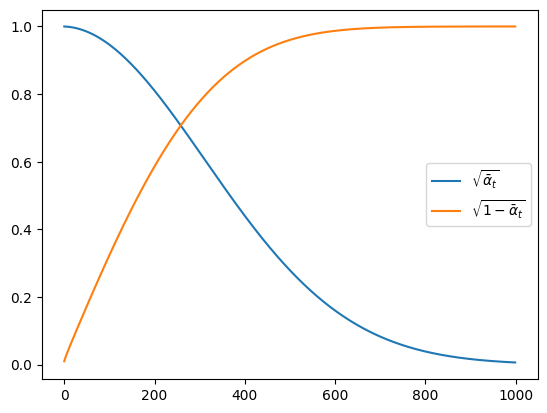

In [90]:
a = np.array([ [np.sqrt(alpha_bar[t]), np.sqrt(1-alpha_bar[t])] for t in range(1, T+1)])

plt.plot(a[:,0], label=r"$\sqrt{\bar{\alpha}_t}$")
plt.plot(a[:,1], label=r"$\sqrt{1-\bar{\alpha}_t}$")

plt.legend()
plt.show()

시간 단계가 흐를 수록 $\sqrt{\bar{\alpha}_t}$는 0이 되고, $\sqrt{1-\bar{\alpha}_t}$는 1이 됩니다. 따라서 $q(\mathbf{x}_t \mid \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t ; \sqrt{\bar{\alpha}_t } \mathbf{x}_0, (1- \bar{\alpha}_t)\mathbf{I})$는 노이즈가 확산 될 수록 점점 표준 정규분포가 되어 간다는 것을 알 수 있습니다.

샘플 $\mathbf{x}_0$에 $\sqrt{\bar{\alpha}_t } \mathbf{x}_0, + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon}$로 $t$ 단계 노이즈를 확신 시키는 함수를 정의합니다. 이 때 샘플 `x`의 모양은 채널이 이미지 크기보다 먼저오는 (N, C, H, W)로 입력 받도록 하겠습니다.

In [91]:
# 숫자값이 들어있는 1차원 어레이에 대한 인덱싱 결과가 4차원 어레이가 되도록 인덱싱 합니다.
alpha_bar[[1], None, None, None].shape

(1, 1, 1, 1)

In [92]:
def perturb_x(x, t, eps):
    # x: (N, C, H, W)

    # x와 alpha_bar[t]가 브로드캐스팅되도록 차원을 늘린수 곱하고 더함
    # alpha_bar[t, None, None, None]: (N,1,1,1)
    # x, eps: (N,C,H,W)
    # 연산결과: (N,C,H,W)
    return np.sqrt(alpha_bar[t, None, None, None]) * x \
            + np.sqrt(1 - alpha_bar[t, None, None, None]) * eps

`sprites`로부터 적당히 샘플 다섯개를 가져오고 임의 시간 단계 `t`를 만든 다음 샘플 이미지에 적용해보겠습니다.

In [93]:
np.random.seed(102)
idx = np.random.randint(0, sprites.shape[0], 5)

x = (sprites[idx].transpose(0, 3, 1, 2)  / 255) * 2 - 1

t = np.random.randint(1, T+1, (x.shape[0],))
noise = np.random.randn(*x.shape)
xt = perturb_x(x, t, noise)
xt_prev = perturb_x(x, t-1, noise)

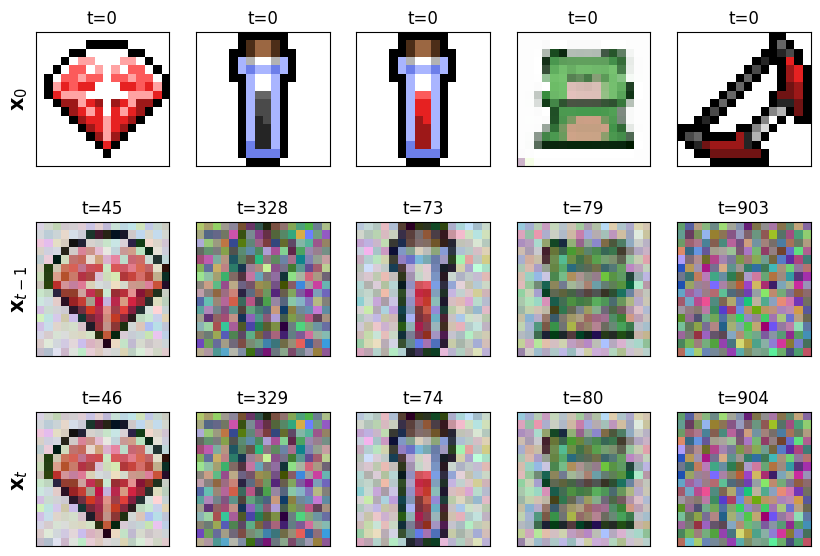

In [94]:
fig, ax = plt.subplots(figsize=(10,7), nrows=3, ncols=5)

for i in range(5):
    x_i = ((x[i] - x[i].min()) / (x[i].max() - x[i].min())).clip(0,1)
    ax[0][i].imshow(x_i.transpose(1,2,0))
    ax[0][i].set_title(f"t={0}")
    ax[0][i].set_xticks([])
    ax[0][i].set_yticks([])

    x_i = ((xt_prev[i] - xt_prev[i].min()) / (xt_prev[i].max() - xt_prev[i].min())).clip(0,1)
    ax[1][i].imshow(x_i.transpose(1,2,0))
    ax[1][i].set_title(f"t={t[i]-1}")
    ax[1][i].set_xticks([])
    ax[1][i].set_yticks([])

    x_i = ((xt[i] - xt[i].min()) / (xt[i].max() - xt[i].min())).clip(0,1)
    ax[2][i].imshow(x_i.transpose(1,2,0))
    ax[2][i].set_title(f"t={t[i]}")
    ax[2][i].set_xticks([])
    ax[2][i].set_yticks([])

    if i == 0:
        ax[0][i].set_ylabel(r"$\mathbf{x}_0$", size=15)
        ax[1][i].set_ylabel(f"$\mathbf{{x}}_{{t-1}}$", size=15)
        ax[2][i].set_ylabel(f"$\mathbf{{x}}_{{t}}$", size=15)

plt.show()

이미지 위에 시간 단계를 표시했습니다. 시간 단계를 건너뛰면서 빠르게 노이즈가 추가되는것을 확인할 수 있습니다. 샘플링이 훨씬 빠르게 가능해졌으므로 이 샘플들을 이용해서 효율적으로 손실함수에 나타나는 $p_\theta(\mathbf{x}_{t-1}\mid \mathbf{x}_t)$, $q(\mathbf{x}_t \mid \mathbf{x}_{t-1})$를 계산할 수 있게 되었습니다.
  
  
$$
p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t ) := \mathcal{N} \left(\mathbf{x}_{t-1}; \boldsymbol{\mu}_\theta (\mathbf{x}_t, t), \boldsymbol{\Sigma}_\theta(\mathbf{x}_t, t)\right)
$$


$$
q(\mathbf{x}_t \mid \mathbf{x}_{t-1}) := \mathcal{N}(\mathbf{x}_t ; \sqrt{1-\beta_t} \mathbf{x}_{t-1} , \beta_t \mathbf{I})
$$

지금까지 식(3)에 대해서 자세히 알아봤습니다. 이론적인 부분 뿐만 아니라 실제 학습에 사용할 수 있을 정도로 코드 수준에서 값을 직접 계산까지 해봤습니다.

DDPM 논문을 보면 이렇게 유도된 손실함수를 바로 사용하지 않고 한번 더 형태를 변형하여 손실함수를 좀 더 간단하게 만들어 사용합니다. DDPM 식(3)에서 식(5)를 유도하는 과정입니다. 논문 부록에 이 과정이 아주 간략하게 소개 되어 있으므로 여기서 자세히 알아보도록 하겠습니다. 다시 식(3)을 보겠습니다.

$$
\mathbb{E}_{q(\mathbf{x}_0)} \left[ - \log p_{\theta}(\mathbf{x}_0) \right] \le \mathbb{E}_{q(\mathbf{x}_{0:T})} \left[ -\log \left( \frac{p_\theta (\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T} \mid \mathbf{x}_0)}\right) \right] = \mathbb{E}_{q(\mathbf{x}_{0:T})} \left[  - \log p(\mathbf{x}_T) - \sum_{t=1}^T \log  \frac{p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t)}{q(\mathbf{x}_t \mid \mathbf{x}_{t-1})} \right] := L \tag{3}
$$

우선 $\sum$ 이하 로그 분수 부분을 변형하기 위해 분모를 봅시다. 분모에 베이즈 정리를 적용하면 다음처럼 쓸 수 있습니다.

$$
q(\mathbf{x}_t \mid \mathbf{x}_{t-1})=\frac{q(\mathbf{x}_{t-1}\mid \mathbf{x}_t) q(\mathbf{x}_t)}{q(\mathbf{x}_{t-1})}
$$

앞서 가정한 마르코프 성질에 의해 좌변은 $q(\mathbf{x}_t \mid \mathbf{x}_{t-1})=q(\mathbf{x}_t \mid \mathbf{x}_{t-1}, \mathbf{x}_0)$ 이며 우변의 다른 항들도 마찬가지 성질을 보이므로 다음처럼 써도 무방합니다.


$$
q(\mathbf{x}_t \mid \mathbf{x}_{t-1})= q(\mathbf{x}_t \mid \mathbf{x}_{t-1}, \mathbf{x}_0)=\frac{q(\mathbf{x}_{t-1}\mid \mathbf{x}_t, \mathbf{x}_0) q(\mathbf{x}_t\mid \mathbf{x}_0)}{q(\mathbf{x}_{t-1}\mid \mathbf{x}_0)}
$$

이 결과를 $\log  \frac{p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t)}{q(\mathbf{x}_t \mid \mathbf{x}_{t-1})}$에 대입하고 정리합니다.

$$
\begin{aligned}
\log  \frac{p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t)}{q(\mathbf{x}_t \mid \mathbf{x}_{t-1})} &=
\log \frac{p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t)}{\dfrac{q(\mathbf{x}_{t-1}\mid \mathbf{x}_t, \mathbf{x}_0) q(\mathbf{x}_t\mid \mathbf{x}_0)}{q(\mathbf{x}_{t-1}\mid \mathbf{x}_0)}}\\[10pt]
&= \log \frac{p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t)}{q(\mathbf{x}_{t-1}\mid \mathbf{x}_t, \mathbf{x}_0)  \dfrac{q(\mathbf{x}_t\mid \mathbf{x}_0)}{q(\mathbf{x}_{t-1}\mid \mathbf{x}_0)}} \\[10pt]
&= \log \frac{p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t)}{q(\mathbf{x}_{t-1}\mid \mathbf{x}_t, \mathbf{x}_0)} \cdot \frac{q(\mathbf{x}_{t-1}\mid \mathbf{x}_0)}{q(\mathbf{x}_t\mid \mathbf{x}_0)}
\end{aligned}
$$

위 결과를 식(3)에 대입하고 정리합니다.

$$
\begin{aligned}
L &= \mathbb{E}_{q(\mathbf{x}_{0:T})} \left[ -\log \left( \frac{p_\theta (\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T} \mid \mathbf{x}_0)}\right) \right]\\[10pt]
&= \mathbb{E}_{q(\mathbf{x}_{0:T})} \left[  - \log p(\mathbf{x}_T) - \sum_{t=1}^T \log  \frac{p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t)}{q(\mathbf{x}_t \mid \mathbf{x}_{t-1})} \right] \\[10pt]
&= \mathbb{E}_{q(\mathbf{x}_{0:T})} \left[  - \log p(\mathbf{x}_T) - \sum_{t=2}^T \log  \frac{p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t)}{q(\mathbf{x}_t \mid \mathbf{x}_{t-1})}  - \log \frac{p_\theta(\mathbf{x}_0\mid\mathbf{x}_1)}{q(\mathbf{x}_1\mid\mathbf{x}_0)} \right] \\[10pt]
&= \mathbb{E}_{q(\mathbf{x}_{0:T})} \left[  - \log p(\mathbf{x}_T) - \sum_{t=2}^T \log \frac{p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t)}{q(\mathbf{x}_{t-1}\mid \mathbf{x}_t, \mathbf{x}_0)} \cdot \frac{q(\mathbf{x}_{t-1}\mid \mathbf{x}_0)}{q(\mathbf{x}_t\mid \mathbf{x}_0)}  - \log \frac{p_\theta(\mathbf{x}_0\mid\mathbf{x}_1)}{q(\mathbf{x}_1\mid\mathbf{x}_0)} \right] \quad (20)
\end{aligned}
$$


여기까지가 논문 부록에 제시된 식(20)까지 입니다. 로그 곱셈을 덧셈으로 바꾸고 정리합니다.

$$
\begin{aligned}
L &= \mathbb{E}_{q(\mathbf{x}_{0:T})} \left[  - \log p(\mathbf{x}_T) - \sum_{t=2}^T \log \frac{p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t)}{q(\mathbf{x}_{t-1}\mid \mathbf{x}_t, \mathbf{x}_0)} \cdot \frac{q(\mathbf{x}_{t-1}\mid \mathbf{x}_0)}{q(\mathbf{x}_t\mid \mathbf{x}_0)}  - \log \frac{p_\theta(\mathbf{x}_0\mid\mathbf{x}_1)}{q(\mathbf{x}_1\mid\mathbf{x}_0)} \right] \\[10pt]
&= \mathbb{E}_{q(\mathbf{x}_{0:T})} \left[  - \log p(\mathbf{x}_T) - \sum_{t=2}^T \left\{ \log \frac{p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t)}{q(\mathbf{x}_{t-1}\mid \mathbf{x}_t, \mathbf{x}_0)} + \log \frac{q(\mathbf{x}_{t-1}\mid \mathbf{x}_0)}{q(\mathbf{x}_t\mid \mathbf{x}_0)} \right\} - \log \frac{p_\theta(\mathbf{x}_0\mid\mathbf{x}_1)}{q(\mathbf{x}_1\mid\mathbf{x}_0)} \right] \\[10pt]
&= \mathbb{E}_{q(\mathbf{x}_{0:T})} \left[  - \log p(\mathbf{x}_T) - \sum_{t=2}^T  \log \frac{p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t)}{q(\mathbf{x}_{t-1}\mid \mathbf{x}_t, \mathbf{x}_0)} - \sum_{t=2}^T \log \frac{q(\mathbf{x}_{t-1}\mid \mathbf{x}_0)}{q(\mathbf{x}_t\mid \mathbf{x}_0)}  - \log \frac{p_\theta(\mathbf{x}_0\mid\mathbf{x}_1)}{q(\mathbf{x}_1\mid\mathbf{x}_0)} \right]
\end{aligned}
$$

세 번째 항에 합산 기호를 전개하면 대부분 항이 삭제되고 다음처럼 됩니다.

$$
\begin{aligned}
-\sum_{t=2}^T \log \frac{q(\mathbf{x}_{t-1}\mid \mathbf{x}_0)}{q(\mathbf{x}_t\mid \mathbf{x}_0)} = - &( \log q(\mathbf{x}_1\mid\mathbf{x}_0) - \log q(\mathbf{x}_2\mid\mathbf{x}_0) ) \\
- &( \log q(\mathbf{x}_2\mid\mathbf{x}_0) - \log q(\mathbf{x}_3\mid\mathbf{x}_0) ) - \cdots \\[10pt]
- &( \log q(\mathbf{x}_{T-1}\mid\mathbf{x}_0) - \log q(\mathbf{x}_T\mid\mathbf{x}_0) ) \\[10pt]
=  - &\log q(\mathbf{x}_1 \mid \mathbf{x}_0 ) + \log q(\mathbf{x}_T \mid \mathbf{x}_0)
\end{aligned}
$$

이를 원 식에 대입하고 정리하면 논문의 식(21)이 완성됩니다.

$$
\begin{aligned}
L &= \mathbb{E}_{q(\mathbf{x}_{0:T})} \left[  - \log p(\mathbf{x}_T) - \sum_{t=2}^T  \log \frac{p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t)}{q(\mathbf{x}_{t-1}\mid \mathbf{x}_t, \mathbf{x}_0)} - \sum_{t=2}^T \log \frac{q(\mathbf{x}_{t-1}\mid \mathbf{x}_0)}{q(\mathbf{x}_t\mid \mathbf{x}_0)}  - \log \frac{p_\theta(\mathbf{x}_0\mid\mathbf{x}_1)}{q(\mathbf{x}_1\mid\mathbf{x}_0)} \right] \\[10pt]
&= \mathbb{E}_{q(\mathbf{x}_{0:T})} \left[  - \log p(\mathbf{x}_T) - \sum_{t=2}^T  \log \frac{p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t)}{q(\mathbf{x}_{t-1}\mid \mathbf{x}_t, \mathbf{x}_0)} - \log q(\mathbf{x}_1 \mid \mathbf{x}_0 ) + \log q(\mathbf{x}_T \mid \mathbf{x}_0) - \log \frac{p_\theta(\mathbf{x}_0\mid\mathbf{x}_1)}{q(\mathbf{x}_1\mid\mathbf{x}_0)} \right] \\[10pt]
&= \mathbb{E}_{q(\mathbf{x}_{0:T})} \left[  - \log p(\mathbf{x}_T) + \log q(\mathbf{x}_T \mid \mathbf{x}_0) - \sum_{t=2}^T  \log \frac{p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t)}{q(\mathbf{x}_{t-1}\mid \mathbf{x}_t, \mathbf{x}_0)} - \log q(\mathbf{x}_1 \mid \mathbf{x}_0 )  - \log p_\theta(\mathbf{x}_0\mid\mathbf{x}_1) + \log q(\mathbf{x}_1\mid\mathbf{x}_0) \right] \\[10pt]
&= \mathbb{E}_{q(\mathbf{x}_{0:T})} \left[  - \log \frac{p(\mathbf{x}_T)}{q(\mathbf{x}_T \mid \mathbf{x}_0)} - \sum_{t=2}^T  \log \frac{p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t)}{q(\mathbf{x}_{t-1}\mid \mathbf{x}_t, \mathbf{x}_0)} - \log p_\theta(\mathbf{x}_0\mid\mathbf{x}_1) \right] \quad(21)
\end{aligned}
$$

식(21)에서 기댓값 연산을 쪼개고 나서 각 항에 $D_{KL}$을 적용합니다.

$$
\begin{aligned}
L =& \mathbb{E}_{q(\mathbf{x}_{0:T})} \left[  - \log \frac{p(\mathbf{x}_T)}{q(\mathbf{x}_T \mid \mathbf{x}_0)} - \sum_{t=2}^T  \log \frac{p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t)}{q(\mathbf{x}_{t-1}\mid \mathbf{x}_t, \mathbf{x}_0)} - \log p_\theta(\mathbf{x}_0\mid\mathbf{x}_1) \right] \quad(21) \\[10pt]
=& \mathbb{E}_{q(\mathbf{x}_{0:T})} \left[ - \log \frac{p(\mathbf{x}_T)}{q(\mathbf{x}_T \mid \mathbf{x}_0)}  \right] + \mathbb{E}_{q(\mathbf{x}_{0:T})} \left[ - \sum_{t=2}^T  \log \frac{p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t)}{q(\mathbf{x}_{t-1}\mid \mathbf{x}_t, \mathbf{x}_0)} \right] + \mathbb{E}_{q(\mathbf{x}_{0:T})} \left[ - \log p_\theta(\mathbf{x}_0\mid\mathbf{x}_1) \right] \\[10pt]
=& \mathbb{E}_{q(\mathbf{x}_0)} \left[ \mathbb{E}_{q(\mathbf{x}_{1:T}\mid\mathbf{x}_0)} \left[ - \log \frac{p(\mathbf{x}_T)}{q(\mathbf{x}_T \mid \mathbf{x}_0)} \right] \right] \quad (\ast) \\[10pt]
+ &\mathbb{E}_{q(\mathbf{x}_0)} \left[ \mathbb{E}_{q(\mathbf{x}_{1:T}\mid\mathbf{x}_0)} \left[  - \sum_{t=2}^T  \log \frac{p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t)}{q(\mathbf{x}_{t-1}\mid \mathbf{x}_t, \mathbf{x}_0)}  \right] \right] \quad (\ast\ast)\\[10pt]
+ &\mathbb{E}_{q(\mathbf{x}_{0:T})} \left[ - \log p_\theta(\mathbf{x}_0\mid\mathbf{x}_1) \right] \quad (\ast\ast\ast)
\end{aligned}
$$

이렇게 분리된 기댓값 연산 (\*), (\*\*), (***)를 $D_{KL}$ 형태로 정리하면 식(5)가 완성됩니다. 여기서 [$D_{KL}$의 정의](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)를 다시 확인하고 이 꼴로 위 식을 변형해야 합니다. $D_{KL}$은 연속 확률 변수 $P \sim p(x)$, $Q \sim q(x)$에 대해서 다음과 같이 정의 됩니다.

$$
D_{KL}(Q || P) = - \int  q(x) \log \frac{p(x)}{q(x)} dx
$$

$D_{KL}$의 정의와 (\*)를 비교해보면 (\*)에서 적분 변수는 $\mathbf{x}_T$라는 것을 알 수 있습니다. 나머지 변수들을 주변화 시킬 수 있습니다. 간단한 스칼라 함수에 대한 주변화 과정을 다음에 정리했습니다.

$$
\begin{aligned}
\mathbb{E}_{q(x_1, x_2, x_3)} [ f(x_1, x_2) ] &= \int_{x_3} \int_{x_2} \int_{x_1} q(x_1, x_2, x_3) f(x_1, x_2) dx_1 dx_2 dx_3 \\[10pt]
&= \int_{x_2} \int_{x_1} \int_{x_3} q(x_1, x_2, x_3) f(x_1, x_2) dx_3 dx_1 dx_2 \quad  \because \text{Fubini's theorem} \\[10pt]
&=\int_{x_2} \int_{x_1} f(x_1, x_2)  \int_{x_3} q(x_1, x_2, x_3) dx_3 dx_1 dx_2 \\[10pt]
&= \int_{x_2} \int_{x_1} f(x_1, x_2)  dx_1 dx_2 \quad \because \text{marginalization}\\[10pt]
&= \mathbb{E}_{q(x_1,x_2)} [f(x_1, x_2)]
\end{aligned}
$$

적분 변수 $x_3$이 사라졌습니다. 이처럼 (*)에서 $\mathbf{x}_1$, ... $\mathbf{x}_{T-1}$을 모두 주변화 해서 없애면 다음처럼 정리할 수 있습니다.

$$
\mathbb{E}_{q(\mathbf{x}_0)} \left[ \mathbb{E}_{q(\mathbf{x}_{1:T}\mid\mathbf{x}_0)} \left[ - \log \frac{p(\mathbf{x}_T)}{q(\mathbf{x}_T \mid \mathbf{x}_0)} \right] \right] = \mathbb{E}_{q(\mathbf{x}_0)} \left[ \mathbb{E}_{q(\mathbf{x}_{T}\mid\mathbf{x}_0)} \left[ - \log \frac{p(\mathbf{x}_T)}{q(\mathbf{x}_T \mid \mathbf{x}_0)} \right] \right] = \mathbb{E}_{q(\mathbf{x}_0)} \left[ D_{KL}(q(\mathbf{x}_T \mid \mathbf{x}_0) || p(\mathbf{x}_T)) \right] \quad (*)
$$



(\*\*) 부분도 마찬가지로 주변화 과정을 거치고 다음처럼 $D_{KL}$ 형태로 바꿀 수 있습니다.

$$
\begin{aligned}
\mathbb{E}_{q(\mathbf{x}_0)} \left[ \mathbb{E}_{q(\mathbf{x}_{1:T}\mid\mathbf{x}_0)} \left[  - \sum_{t=2}^T  \log \frac{p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t)}{q(\mathbf{x}_{t-1}\mid \mathbf{x}_t, \mathbf{x}_0)}  \right] \right]
&= \mathbb{E}_{q(\mathbf{x}_0)} \left[ - \sum_{t=2}^T \mathbb{E}_{q(\mathbf{x}_{1:T}\mid\mathbf{x}_0)} \left[   \log \frac{p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t)}{q(\mathbf{x}_{t-1}\mid \mathbf{x}_t, \mathbf{x}_0)}  \right] \right] \\[10pt]
&= \mathbb{E}_{q(\mathbf{x}_0)} \left[ - \sum_{t=2}^T \mathbb{E}_{q(\mathbf{x}_{t-1},\mathbf{x}_{t}\mid\mathbf{x}_0)} \left[    \log \frac{p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t)}{q(\mathbf{x}_{t-1}\mid \mathbf{x}_t, \mathbf{x}_0)}  \right] \right] \\[10pt]
&= \mathbb{E}_{q(\mathbf{x}_0)} \left[  - \sum_{t=2}^T \mathbb{E}_{q(\mathbf{x}_{t}\mid\mathbf{x}_0)} \left[  \mathbb{E}_{q(\mathbf{x}_{t-1}\mid\mathbf{x}_t, \mathbf{x}_0)}\left[   \log \frac{p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t)}{q(\mathbf{x}_{t-1}\mid \mathbf{x}_t, \mathbf{x}_0)}  \right] \right] \right] \\[10pt]
&= \mathbb{E}_{q(\mathbf{x}_0)} \left[ \sum_{t=2}^T \mathbb{E}_{q(\mathbf{x}_{t}\mid\mathbf{x}_0)} \left[   - \mathbb{E}_{q(\mathbf{x}_{t-1}\mid\mathbf{x}_t, \mathbf{x}_0)}\left[  \log \frac{p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t)}{q(\mathbf{x}_{t-1}\mid \mathbf{x}_t, \mathbf{x}_0)}  \right] \right] \right] \\[10pt]
&= \mathbb{E}_{q(\mathbf{x}_0)} \left[ \sum_{t=2}^T \mathbb{E}_{q(\mathbf{x}_{t}\mid\mathbf{x}_0)} \left[     D_{KL}(q(\mathbf{x}_{t-1}\mid \mathbf{x}_t, \mathbf{x}_0) || p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t))  \right] \right] \\[10pt]
&=\sum_{t=2}^T \mathbb{E}_{q(\mathbf{x}_0, \mathbf{x}_t)} \left[      D_{KL}(q(\mathbf{x}_{t-1}\mid \mathbf{x}_t, \mathbf{x}_0) || p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t))  \right] \quad (**)
\end{aligned}
$$

(\*\*\*) 부분도 간단히 주변화 해서 다음처럼 정리한 다음

$$
\begin{aligned}
\mathbb{E}_{q(\mathbf{x}_{0:T})} \left[   - \log p_\theta(\mathbf{x}_0\mid\mathbf{x}_1) \right] &= \mathbb{E}_{q(\mathbf{x}_{0})} \left[ \mathbb{E}_{q(\mathbf{x}_{1:T} \mid \mathbf{x}_0)} [- \log p_\theta(\mathbf{x}_0\mid\mathbf{x}_1) ] \right] \\[5pt]
&= \mathbb{E}_{q(\mathbf{x}_{0})} \left[ \mathbb{E}_{q(\mathbf{x}_{1} \mid \mathbf{x}_0)} [- \log p_\theta(\mathbf{x}_0\mid\mathbf{x}_1) ] \right] \\[5pt]
&= \mathbb{E}_{q(\mathbf{x}_{0}, \mathbf{x}_1)} \left[ - \log p_\theta(\mathbf{x}_0\mid\mathbf{x}_1) \right] \quad (***)
\end{aligned}
$$

유도된 세 부분을 함께 쓰면 다음과 같습니다.

$$
L = \mathbb{E}_{q(\mathbf{x}_0)} \left[ D_{KL}(q(\mathbf{x}_T \mid \mathbf{x}_0) || p(\mathbf{x}_T)) \right] + \sum_{t=2}^T \mathbb{E}_{q(\mathbf{x}_0, \mathbf{x}_t)} \left[      D_{KL}(q(\mathbf{x}_{t-1}\mid \mathbf{x}_t, \mathbf{x}_0) || p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t))  \right] + \mathbb{E}_{q(\mathbf{x}_{0}, \mathbf{x}_1)} \left[ - \log p_\theta(\mathbf{x}_0\mid\mathbf{x}_1) \right]
$$

이제 각 항에 주변화해서 없앤 적분 변수를 다시 넣어서 $\mathbf{x}_{0:T}$에 대한 적분으로 바꾸면 다음처럼 정리 됩니다.


$$
L = \mathbb{E}_{q(\mathbf{x}_{0:T})} \left[ \underbrace{D_{KL}(q(\mathbf{x}_T \mid \mathbf{x}_0) || p(\mathbf{x}_T))}_{L_T} +   \sum_{t=2}^T    \underbrace{D_{KL}(q(\mathbf{x}_{t-1}\mid \mathbf{x}_t, \mathbf{x}_0) || p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t))}_{L_{t-1}}   \underbrace{ - \log p_\theta(\mathbf{x}_0\mid\mathbf{x}_1)}_{L_0} \right] \tag{5}
$$

이렇게 식(5)를 완전히 유도 했습니다.

식(5)는 손실 함수 식(3)이 $L_T$, $L_{t-1}$, $L_0$ 세 부분으로 변형된 형태이며 앞 두 항은 $D_{KL}$이고 마지막 항 $L_0$은 리버스 프로세스에서 마지막 과정에 해당하는 마이너스 로그 가능도 입니다. 이 세 항을 모두 줄여야 하는 사실은 변함이 없고 식(3)에서 형태만 바뀐 상태입니다.

각 항의 의미를 살펴보도록 합시다.







### $L_T$

$\mathbf{x}_0$로부터 완전히 노이즈 상태가 된 $\mathbf{x}_T$의 분포가 표준 정규분포 $p(\mathbf{x}_T)$와 얼마나 비슷한지를 나타냅니다. 이 항은 파라미터 $\theta$에 독립적인 항이므로 무시할 수 있습니다.

### $L_{1:T-1}$



<img src="https://raw.githubusercontent.com/metamath1/imgs/main/diffusion/ddpm-fig2_mod.png" style="width: 100%;" alt="ddpm figure2 mod" border="1px solid black"/>

복잡한 이야기를 다 떠나서 우리가 궁극적으로 알고 싶은 것은 $q(\mathbf{x}_0 \mid \mathbf{x}_T)$ 또는 $q(\mathbf{x}_{t-1} \mid \mathbf{x}_t)$입니다. 전자는 모든 시간 단계를 건더뛰고 완전 노이즈와 이미지를 바로 연결하는 조건부 분포이므로 이를 직접 알기는 힘듭니다. 대신 각 시간 단계에 대한 리버스 프로세스를 알려주는 $q(\mathbf{x}_{t-1} \mid \mathbf{x}_t)$를 알아도 됩니다. $q(\mathbf{x} \mid \mathbf{x}_{t-1})$를 알고 있기 때문에 여기에 베이즈 정리를 이용해서 이론적으로 유도 할 수 있지만 실제 계산을 위해서 모든 시간 단계에 대한 $q(\mathbf{x}_t)$를 알아야 합니다.

$$
q(\mathbf{x}_{t-1} \mid \mathbf{x}_t) = \frac{q(\mathbf{x}_t \mid \mathbf{x}_{t-1})q(\mathbf{x}_{t-1})}{q(\mathbf{x}_t)}
$$

$q(\mathbf{x}_{t-1} \mid \mathbf{x}_t)$는 알 수 없지만 식(5)에 나타난 포워드 프로세스의 posterior $q(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0)$는 계산할 수 있습니다. 이를 위해 먼저 다음 베이즈 정리를 이용합니다.

$$
\begin{aligned}
p(x \mid y, z) &= \frac{p(x, y, z)}{p(y,z)} \\[5pt]
&= \frac{p(y \mid x, z)p(x,z)}{p(y,z)} \\[5pt]
&= \frac{p(y \mid x, z)p(x \mid z)p(z)}{p(y \mid z)p(z)} \\[5pt]
&= \frac{p(y \mid x, z)p(x \mid z)}{p(y \mid z)}
\end{aligned}
$$

위 베이즈 정리를 $q(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0)$에 적용합니다.

$$
q(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0)=\frac{q(\mathbf{x}_t \mid \mathbf{x}_{t-1}, \mathbf{x}_0)q(\mathbf{x}_{t-1} \mid \mathbf{x}_0)}{q(\mathbf{x}_t \mid \mathbf{x}_0)} = \frac{q(\mathbf{x}_t \mid \mathbf{x}_{t-1})q(\mathbf{x}_{t-1} \mid \mathbf{x}_0)}{q(\mathbf{x}_t \mid \mathbf{x}_0)}
$$

두 번째 등호는 마르코프 가정을 사용했습니다. 이제 $q(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0)$가 계산할 수 있는 항 3개로 변환되었습니다. $q(\mathbf{x}_{t-1} \mid \mathbf{x}_0)$, $q(\mathbf{x}_t \mid \mathbf{x}_0)$는 식(4)에 의해 $q(\mathbf{x}_t \mid \mathbf{x}_{t-1})$는 포워드 프로세스의 정의에 의해 계산할 수 있습니다. 이 계산을 마치면 DDPM의 식(6), (7)이 유도됩니다. 이 과정은 어렵진 않지만 상당히 지저분하고 지루한 과정이므로 다음 제시된 계산 과정은 스킵하여도 무방합니다.

$$
\begin{aligned}
q(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0) &=\frac{q(\mathbf{x}_t \mid \mathbf{x}_{t-1})q(\mathbf{x}_{t-1} \mid \mathbf{x}_0)}{q(\mathbf{x}_t \mid \mathbf{x}_0)} \\[10pt]
&= \frac{\mathcal{N}(\mathbf{x}_t ; \sqrt{1-\beta_t}\mathbf{x}_{t-1}, \beta_t \mathbf{I}) \,\, \mathcal{N}(\mathbf{x}_{t-1}; \sqrt{\bar{\alpha}_{t-1}} \mathbf{x}_0, (1-\bar{\alpha}_{t-1})\mathbf{I})}{\mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t}\mathbf{x}_0, (1-\bar{\alpha}_{t})\mathbf{I})} \quad (*)
\end{aligned}
$$

한편 $\mathbf{x} \in \mathbb{R}^D$인 벡터 변수에 대한 정규분포는 다음과 같고

$$
\mathcal{N}(\mathbf{x}, \boldsymbol{\mu}, \Sigma) = \frac{1}{(\sqrt{2\pi})^D \sqrt{|\Sigma|}} \exp \left\{-\frac{1}{2} (\mathbf{x}-\boldsymbol{\mu})^T \Sigma^{-1} (\mathbf{x}-\boldsymbol{\mu}) \right\}
$$

지금 다루고 있는 $\mathcal{N}(\mathbf{x}_t ; \sqrt{1-\beta_t}\mathbf{x}_{t-1}, \beta_t \mathbf{I}) $처럼 공분산 행렬이 $\Sigma = \beta \, \mathbf{I}$인 경우 다음처럼 간소화 됩니다.

$$
\mathcal{N}(\mathbf{x}, \boldsymbol{\mu}, \Sigma) = \frac{1}{(\sqrt{2\pi})^D \sqrt{\beta^D}} \exp\left\{-\frac{1}{2\beta} (\mathbf{x}-\boldsymbol{\mu})^T (\mathbf{x}-\boldsymbol{\mu})\right\}
$$

그리고 벡터의 행렬곱은 다음처럼 전개할 수 있으므로

$$
\begin{aligned}
(\mathbf{x}-\boldsymbol{\mu})^T (\mathbf{x}-\boldsymbol{\mu}) &= (\mathbf{x}^T-\boldsymbol{\mu}^T)(\mathbf{x}-\boldsymbol{\mu}) \\[5pt]
&= \mathbf{x}^T \mathbf{x} - \mathbf{x}^T \boldsymbol{\mu} - \boldsymbol{\mu}^T \mathbf{x} + \boldsymbol{\mu}^T\boldsymbol{\mu} \\[5pt]
&= \lVert\mathbf{x}\rVert^2_2 - 2 \mathbf{x}^T \boldsymbol{\mu} + \lVert \boldsymbol{\mu} \rVert^2_2
\end{aligned}
$$

이를 이용해 (\*)를 전개합니다.

$$
\begin{aligned}
q(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0) &= \frac{\mathcal{N}(\mathbf{x}_t ; \sqrt{1-\beta_t}\mathbf{x}_{t-1}, \beta_t \mathbf{I}) \,\, \mathcal{N}(\mathbf{x}_{t-1}; \sqrt{\bar{\alpha}_{t-1}} \mathbf{x}_0, (1-\bar{\alpha}_{t-1})\mathbf{I})}{\mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t}\mathbf{x}_0, (1-\bar{\alpha}_{t})\mathbf{I})} \quad (*) \\[10pt]
&= \frac{ \frac{1}{\sqrt{(2\pi)^D}\sqrt{(1-\alpha_t)^D}} \exp\left\{-\frac{1}{2(1-\alpha_t)} (\mathbf{x}_t - \sqrt{\alpha_t}\mathbf{x}_{t-1})^T (\mathbf{x}_t - \sqrt{\alpha_t}\mathbf{x}_{t-1}) \right\} \times \frac{1}{\sqrt{(2\pi)^D}\sqrt{(1-\bar{\alpha}_{t-1})^D}} \exp\left\{-\frac{1}{2(1-\bar{\alpha}_{t-1})} (\mathbf{x}_{t-1} - \sqrt{\bar{\alpha}_{t-1}}\mathbf{x}_{0})^T (\mathbf{x}_{t-1} - \sqrt{\bar{\alpha}_{t-1}}\mathbf{x}_{0}) \right\}  }{  \frac{1}{\sqrt{(2\pi)^D}\sqrt{(1-\bar{\alpha}_{t})^D}} \exp\left\{-\frac{1}{2(1-\bar{\alpha}_{t})} (\mathbf{x}_{t} - \sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0})^T (\mathbf{x}_{t} - \sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0}) \right\}  } \\[10pt]
&=\frac{ \frac{1}{(2\pi)^D\sqrt{(1-\alpha_t)^D (1-\bar{\alpha}_{t-1})^D}} \exp\left\{ -\left(  \overbrace{\frac{\lVert \mathbf{x}_t - \sqrt{\alpha_t} \mathbf{x}_{t-1} \rVert^2_2}{2(1-\alpha_t)}}^{A} + \overbrace{\frac{\lVert \mathbf{x}_{t-1} - \sqrt{\bar\alpha_{t-1}} \mathbf{x}_{0} \rVert^2_2}{2(1-\bar{\alpha}_{t-1})} }^{B} \right) \right\}  }{ \frac{1}{\sqrt{(2\pi)^D}\sqrt{(1-\bar{\alpha}_{t})^D}} \exp \left\{ - \frac{1}{2(1-\bar{\alpha}_{t})} \lVert \mathbf{x}_{t} - \sqrt{\bar\alpha_{t}} \mathbf{x}_{0} \rVert^2_2 \right\} } \\[10pt]
&= \underbrace{\frac{\sqrt{(2\pi)^D}\sqrt{(1-\bar{\alpha}_{t})^D}}{(2\pi)^D\sqrt{(1-\alpha_t)^D (1-\bar{\alpha}_{t-1})^D}}}_{C_1} \exp \left\{ -(A+B) - \left(- \frac{1}{2(1-\bar{\alpha}_{t})} \lVert \mathbf{x}_{t} - \sqrt{\bar\alpha_{t}} \mathbf{x}_{0} \rVert^2_2 \right)  \right\} \\[10pt]
&= C_1 \exp \left\{ - \left( \frac{\lVert \mathbf{x}_t - \sqrt{\alpha_t} \mathbf{x}_{t-1} \rVert^2_2}{2(1-\alpha_t)} +  \frac{\lVert \mathbf{x}_{t-1} - \sqrt{\bar\alpha_{t-1}} \mathbf{x}_{0} \rVert^2_2}{2(1-\bar{\alpha}_{t-1})} - \frac{\lVert \mathbf{x}_{t} - \sqrt{\bar\alpha_{t}} \mathbf{x}_{0} \rVert^2_2 }{2(1-\bar{\alpha}_{t})} \right) \right\}
\end{aligned}
$$

마지막에 이 상수 $C_1$이 어떤 정규분포의 정규화 상수와 일치하게 되는 것을 확인할 있습니다.

이제 $||\cdot||^2_2$ 부분을 전개하고

$$
\begin{aligned}
q(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0) &= C_1 \exp \left\{ - \left( \frac{\lVert \mathbf{x}_t - \sqrt{\alpha_t} \mathbf{x}_{t-1} \rVert^2_2}{2(1-\alpha_t)} +  \frac{\lVert \mathbf{x}_{t-1} - \sqrt{\bar\alpha_{t-1}} \mathbf{x}_{0} \rVert^2_2}{2(1-\bar{\alpha}_{t-1})} - \frac{ \lVert \mathbf{x}_{t} - \sqrt{\bar\alpha_{t}} \mathbf{x}_{0} \rVert^2_2 }{2(1-\bar{\alpha}_{t})} \right) \right\} \\[10pt]
&= C_1 \exp \\
& \left\{ - \frac{1}{2} \left( \frac{ \lVert\mathbf{x}_t \rVert^2_2 - 2 \sqrt{\alpha_t}\mathbf{x}_t^T \mathbf{x}_{t-1} + \alpha_t \lVert\mathbf{x}_{t-1} \rVert^2_2 }{(1-\alpha_t)} +  \frac{ \lVert\mathbf{x}_{t-1} \rVert^2_2 - 2 \sqrt{\bar{\alpha}_{t-1}}\mathbf{x}_{t-1}^T \mathbf{x}_{0} + \bar\alpha_{t-1} \lVert \mathbf{x}_{0} \rVert^2_2  }{(1-\bar{\alpha}_{t-1})} - \frac{ \lVert \mathbf{x}_{t} \rVert^2_2 - 2 \sqrt{\bar{\alpha}_{t}}\mathbf{x}_{t}^T \mathbf{x}_{0} + \bar\alpha_{t} \lVert \mathbf{x}_{0} \rVert^2_2  }{(1-\bar{\alpha}_{t})} \right) \right\}
\end{aligned}
$$

$(\cdot)$ 안을 $\mathbf{x}_{t-1}$,  $\mathbf{x}_0$, $\mathbf{x}_t$ 로 나눠서 정리합니다.

$$
\begin{aligned}
q(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0) &= C_1 \exp \\
& \left\{ - \frac{1}{2} \left( \frac{ - 2 \sqrt{\alpha_t}\mathbf{x}_t^T \mathbf{x}_{t-1} + \alpha_t \lVert\mathbf{x}_{t-1}\rVert^2_2 }{(1-\alpha_t)} +  \frac{ \lVert\mathbf{x}_{t-1} \rVert^2_2 - 2 \sqrt{\bar{\alpha}_{t-1}}\mathbf{x}_{t-1}^T \mathbf{x}_{0} }{(1-\bar{\alpha}_{t-1})} + \overbrace{\frac{ \lVert\mathbf{x}_t\rVert^2_2}{1-\alpha_t} + \frac{\bar\alpha_{t-1} \lVert \mathbf{x}_0 \rVert^2_2}{1-\bar\alpha_{t-1}}- \frac{ \lVert \mathbf{x}_{t} \rVert^2_2 - 2 \sqrt{\bar{\alpha}_{t}}\mathbf{x}_{t}^T \mathbf{x}_{0} + \bar\alpha_{t} \lVert \mathbf{x}_{0} \rVert^2_2  }{(1-\bar{\alpha}_{t})}}^{C_2(\mathbf{x}_0, \mathbf{x}_t)} \right) \right\}
\end{aligned}
$$

$C_2(\mathbf{x}_0, \mathbf{x}_t)$ 부분은 $\mathbf{x}_{t-1}$과 아무 상관이 없는 항입니다. 지금 계산하고 있는 분포 $q(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0)$의 변수는 $\mathbf{x}_{t-1}$임을 다시 한번 상기합시다.

$$
\begin{aligned}
q(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0) &= C_1 \exp \left\{ - \frac{1}{2} \left( \frac{ - 2 \sqrt{\alpha_t}\mathbf{x}_t^T \mathbf{x}_{t-1} + \alpha_t \lVert\mathbf{x}_{t-1}\rVert^2_2 }{(1-\alpha_t)} +  \frac{ \lVert\mathbf{x}_{t-1}\rVert^2_2 - 2 \sqrt{\bar{\alpha}_{t-1}}\mathbf{x}_{t-1}^T \mathbf{x}_{0} }{(1-\bar{\alpha}_{t-1})} + C_2(\mathbf{x}_0, \mathbf{x}_t) \right) \right\} \\[10pt]
&= C_1 \exp \left\{ - \frac{1}{2} \left( \frac{ - 2 \sqrt{\alpha_t}\mathbf{x}_t^T \mathbf{x}_{t-1} + \alpha_t \lVert \mathbf{x}_{t-1} \rVert^2_2 }{(1-\alpha_t)} +  \frac{ \lVert \mathbf{x}_{t-1} \rVert^2_2 - 2 \sqrt{\bar{\alpha}_{t-1}}\mathbf{x}_{0}^T \mathbf{x}_{t-1} }{(1-\bar{\alpha}_{t-1})} + C_2(\mathbf{x}_0, \mathbf{x}_t) \right) \right\} \\[10pt]
&= C_1 \exp \left\{ -\frac{1}{2} \left( \frac{\alpha_t \lVert \mathbf{x}_{t-1} \rVert^2_2}{1-\alpha_t} + \frac{ \lVert \mathbf{x}_{t-1} \rVert^2_2}{1-\bar\alpha_{t-1}} + \frac{- 2 \sqrt{\alpha_t}\mathbf{x}_t^T \mathbf{x}_{t-1}}{1-\alpha_t} + \frac{- 2 \sqrt{\bar{\alpha}_{t-1}}\mathbf{x}_{0}^T \mathbf{x}_{t-1}}{1-\bar\alpha_{t-1}} + C_2(\mathbf{x}_0, \mathbf{x}_t) \right) \right\} \\[10pt]
&= C_1 \exp \left\{  -\frac{1}{2}\left( \left( \frac{\alpha_t}{1-\alpha_t} + \frac{1}{1-\bar\alpha_{t-1}} \right) \lVert \mathbf{x}_{t-1} \rVert^2_2  -2 \left( \frac{\sqrt{\alpha_t}\mathbf{x}_t^T}{1-\alpha_t} + \frac{\sqrt{\bar\alpha_{t-1}}\mathbf{x}_0^T}{1-\bar\alpha_{t-1}} \right) \mathbf{x}_{t-1}  + C_2(\mathbf{x}_0, \mathbf{x}_t)  \right)  \right\} \\[10pt]
&= C_1 \exp \left\{  -\frac{1}{2}\left( \left( \frac{1-\bar\alpha_{t}}{(1-\alpha_t)(1-\bar\alpha_{t-1})} \right) \lVert \mathbf{x}_{t-1} \rVert^2_2  -2 \left( \frac{\sqrt{\alpha_t}\mathbf{x}_t^T}{1-\alpha_t} + \frac{\sqrt{\bar\alpha_{t-1}}\mathbf{x}_0^T}{1-\bar\alpha_{t-1}} \right) \mathbf{x}_{t-1}  + C_2(\mathbf{x}_0, \mathbf{x}_t) \right) \right\} \\[10pt]
&= C_1 \exp \left\{  -\frac{1}{2} \left( \frac{1-\bar\alpha_{t}}{(1-\alpha_t)(1-\bar\alpha_{t-1})} \right) \left[ \lVert \mathbf{x}_{t-1} \rVert^2_2  -2 \left( \frac{\frac{\sqrt{\alpha_t}\mathbf{x}_t^T}{1-\alpha_t} + \frac{\sqrt{\bar\alpha_{t-1}}\mathbf{x}_0^T}{1-\bar\alpha_{t-1}}}{\frac{1-\bar\alpha_{t}}{(1-\alpha_t)(1-\bar\alpha_{t-1})}} \right) \mathbf{x}_{t-1} + \underbrace{\frac{C_2(\mathbf{x}_0, \mathbf{x}_t) }{ \frac{1-\bar\alpha_{t}}{(1-\alpha_t)(1-\bar\alpha_{t-1})} }}_{C_3} \right] \right\} \\[10pt]
&= C_1 \exp \left\{  -\frac{1}{2} \left( \frac{1-\bar\alpha_{t}}{(1-\alpha_t)(1-\bar\alpha_{t-1})} \right) \left[ \lVert \mathbf{x}_{t-1} \rVert^2_2  -2 \left( \frac{\left(\frac{\sqrt{\alpha_t}\mathbf{x}_t^T}{1-\alpha_t} + \frac{\sqrt{\bar\alpha_{t-1}}\mathbf{x}_0^T}{1-\bar\alpha_{t-1}}\right)(1-\alpha_t)(1-\bar\alpha_{t-1})}{1-\bar\alpha_{t}} \right) \mathbf{x}_{t-1} + C_3 \right] \right\} \\[10pt]
&= C_1 \exp \left\{  -\frac{1}{2} \left( \frac{1}{ \frac{(1-\alpha_t)(1-\bar\alpha_{t-1})}{1-\bar\alpha_{t}}   } \right) \left[ \lVert \mathbf{x}_{t-1} \rVert^2_2  -2 \underbrace{\left( \frac{\sqrt{\alpha_t}(1-\bar\alpha_{t-1}) \mathbf{x}_t^T + \sqrt{\bar\alpha_{t-1}}(1-\alpha_t)\mathbf{x}_0^T}{1-\bar\alpha_{t}} \right)}_{\mathbf{v}^T}\mathbf{x}_{t-1} + C_3 \right] \right\}
\end{aligned}
$$

두 번째 등호는 $\mathbf{x}_{t-1}^T\mathbf{x}_0$를 $\mathbf{x}_0^T \mathbf{x}_{t-1}$로 바꿔 적은 것입니다. 전개한 결과를 표준적인 정규분포 모양과 비교해보면

$$
\mathcal{N}(\mathbf{x}, \boldsymbol{\mu}, \Sigma) = \frac{1}{(\sqrt{2\pi})^D \sqrt{\beta^D}} \exp\left\{-\frac{1}{2\beta} (\mathbf{x}-\boldsymbol{\mu})^T (\mathbf{x}-\boldsymbol{\mu})\right\}
$$

다음 두 등식이 성립하면 $q(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0)$는 정규 분포라는 것을 알 수 있습니다.

$$
C_1 = \frac{1}{ (\sqrt{2\pi})^D \sqrt{\left( \frac{(1-\alpha_t)(1-\bar\alpha_{t-1})}{1-\bar\alpha_t} \right)^D}}, \quad C_3 = \mathbf{v}^T \mathbf{v}
$$


먼저 $C_1$부터 정리해보겠습니다.

$$
\begin{aligned}
C_1 &= \frac{\sqrt{(2\pi)^D}\sqrt{(1-\bar{\alpha}_{t})^D}}{(2\pi)^D\sqrt{(1-\alpha_t)^D (1-\bar{\alpha}_{t-1})^D}} \\[5pt]
&= \frac{\sqrt{(2\pi)^D}}{(2\pi)^D} \frac{\left((1-\bar\alpha_t)^{\frac{1}{2}}\right)^D}{\left(((1-\alpha_t)(1-\bar\alpha_{t-1}))^{\frac{1}{2}}\right)^D} \\[5pt]
&= \frac{\left((2\pi)^D\right)^{\frac{1}{2}}}{(2\pi)^D} \frac{1}{\dfrac{\left((1-\alpha_t)(1-\bar\alpha_{t-1})\right)^{\frac{D}{2}}}{(1-\bar\alpha_t)^{\frac{D}{2}}}} \\[5pt]
&= \left(\frac{(2\pi)^{\frac{1}{2}}}{2\pi}\right)^D \frac{1}{\sqrt{\dfrac{(1-\alpha_t)^D(1-\bar\alpha_{t-1})^D}{(1-\bar\alpha_t)^D}}} \\[5pt]
&= \left((2\pi)^{-\frac{1}{2}}\right)^D \frac{1}{\sqrt{\left(\dfrac{(1-\alpha_t)(1-\bar\alpha_{t-1})}{(1-\bar\alpha_t)}\right)^D}} \\[5pt]
&= \frac{1}{ (\sqrt{2\pi})^D \sqrt{\left( \frac{(1-\alpha_t)(1-\bar\alpha_{t-1})}{1-\bar\alpha_t} \right)^D}}
\end{aligned}
$$

마지막으로  $C_3 = \mathbf{v}^T \mathbf{v}$를 보이기 위해 먼저 $\mathbf{v}^T \mathbf{v}$를 계산합니다.

$$
\begin{aligned}
\mathbf{v}^T \mathbf{v} &=  \left(  \frac{\sqrt{\alpha_t}(1-\bar\alpha_{t-1}) \mathbf{x}_t^T }{1-\bar\alpha_{t}} + \frac{ \sqrt{\bar\alpha_{t-1}}(1-\alpha_t)\mathbf{x}_0^T}{1-\bar\alpha_{t}} \right) \left(  \frac{\sqrt{\alpha_t}(1-\bar\alpha_{t-1}) \mathbf{x}_t }{1-\bar\alpha_{t}} + \frac{ \sqrt{\bar\alpha_{t-1}}(1-\alpha_t)\mathbf{x}_0}{1-\bar\alpha_{t}}  \right) \\[10pt]
&= \frac{\alpha_t (1-\bar\alpha_{t-1})^2}{(1-\bar\alpha_t)^2} \mathbf{x}^T_t \mathbf{x}_t + \frac{\sqrt{\alpha_t}\sqrt{\bar\alpha_{t-1}}(1-\bar\alpha_{t-1})(1-\alpha_t)}{(1-\bar\alpha_t)^2} \mathbf{x}^T_t \mathbf{x}_0 + \frac{\sqrt{\bar\alpha_{t-1}}(1-\alpha_t)\sqrt{\alpha_t}(1-\bar\alpha_{t-1})}{(1-\bar\alpha_t)^2} \mathbf{x}^T_0 \mathbf{x}_t + \frac{\bar\alpha_{t-1}(1-\alpha_t)^2}{(1-\bar\alpha_t)^2} \mathbf{x}^T_0 \mathbf{x}_0 \\[10pt]
&= \color{#20639B}{\frac{\alpha_t (1-\bar\alpha_{t-1})^2}{(1-\bar\alpha_t)^2}}
\color{black}{\mathbf{x}^T_t \mathbf{x}_t}
+ \color{#ED553B}{2 \left(\frac{\sqrt{\bar\alpha_{t}}(1-\alpha_t)(1-\bar\alpha_{t-1})}{(1-\bar\alpha_t)^2}\right)}
\color{black}{\mathbf{x}^T_0 \mathbf{x}_t}
+ \color{#3CAEA3}{\frac{\bar\alpha_{t-1}(1-\alpha_t)^2}{(1-\bar\alpha_t)^2}}
\color{black}{\mathbf{x}^T_0 \mathbf{x}_0}
\end{aligned}
$$

다음으로 $C_3$이 방금 전개한 식과 같음을 보이면 $q(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0)$는 정규 분포가 됩니다. 이를 위해 $C_3$ 정의로 부터 식을 전개하도록 하겠습니다.

$$
\begin{aligned}
C_3 &= \frac{C_2(\mathbf{x}_0, \mathbf{x}_1)}{\dfrac{1-\bar\alpha_t}{(1-\alpha_t)(1-\bar\alpha_{t-1})}} \\[10pt]
&= \frac{ \dfrac{\mathbf{x}^T_t \mathbf{x}_t}{1-\alpha_t} + \dfrac{\bar\alpha_{t-1}\mathbf{x}^T_0 \mathbf{x}_0}{1-\bar\alpha_{t-1}} - \dfrac{\mathbf{x}^T_t \mathbf{x}_t - 2 \sqrt{\bar\alpha_t} \mathbf{x}^T_t \mathbf{x}_0 + \bar\alpha_t \mathbf{x}^T_0 \mathbf{x}_0 }{1-\bar\alpha_t} }{\dfrac{1-\bar\alpha_t}{(1-\alpha_t)(1-\bar\alpha_{t-1})}} \\[10pt]
&= \frac{(1-\bar\alpha_{t-1})\mathbf{x}^T_t \mathbf{x}_t + (1-\alpha_t)\bar\alpha_{t-1} \mathbf{x}^T_0 \mathbf{x}_0 - \dfrac{(\mathbf{x}^T_t \mathbf{x}_t - 2 \sqrt{\bar\alpha_t} \mathbf{x}^T_t \mathbf{x}_0 + \bar\alpha_t \mathbf{x}^T_0 \mathbf{x}_0)(1-\alpha_t)(1-\bar\alpha_{t-1})}{1-\bar\alpha_t}}{1-\bar\alpha_t} \\[10pt]
&= \frac{(1-\bar\alpha_{t-1})}{1-\bar\alpha_t}\mathbf{x}^T_t \mathbf{x}_t + \frac{(1-\alpha_t)\bar\alpha_{t-1}}{1-\bar\alpha_t}\mathbf{x}^T_0 \mathbf{x}_0 - \frac{(\mathbf{x}^T_t \mathbf{x}_t - 2 \sqrt{\bar\alpha_t} \mathbf{x}^T_t \mathbf{x}_0 + \bar\alpha_t \mathbf{x}^T_0 \mathbf{x}_0)(1-\alpha_t)(1-\bar\alpha_{t-1})}{(1-\bar\alpha_t)^2} \\[10pt]
&=  \frac{(1-\bar\alpha_{t-1})}{1-\bar\alpha_t}\mathbf{x}^T_t \mathbf{x}_t + \frac{(1-\alpha_t)\bar\alpha_{t-1}}{1-\bar\alpha_t}\mathbf{x}^T_0 \mathbf{x}_0  \\[5pt]
& \quad - \left(
    \frac{(1-\alpha_t)(1-\bar\alpha_{t-1})}{(1-\bar\alpha_t)^2}\mathbf{x}^T_t \mathbf{x}_t  
    - \frac{2 \sqrt{\bar\alpha_t}(1-\alpha_t)(1-\bar\alpha_{t-1})}{(1-\bar\alpha_t)^2} \mathbf{x}^T_t \mathbf{x}_0 + \frac{\bar\alpha_t(1-\alpha_t)(1-\bar\alpha_{t-1})}{(1-\bar\alpha_t)^2}\mathbf{x}^T_0 \mathbf{x}_0
\right) \\[10pt]
&= \color{#20639B}{\left[ \frac{(1-\bar\alpha_{t-1})}{1-\bar\alpha_t} - \frac{(1-\alpha_t)(1-\bar\alpha_{t-1})}{(1-\bar\alpha_t)^2} \right]}
\color{black}{\mathbf{x}^T_t \mathbf{x}_t}
+ \color{#ED553B}{2 \left(\frac{\sqrt{\bar\alpha_{t}}(1-\alpha_t)(1-\bar\alpha_{t-1})}{(1-\bar\alpha_t)^2}\right)}
\color{black}{\mathbf{x}^T_0 \mathbf{x}_t} \\[5pt]
& \quad + \color{#3CAEA3}{\left[ \frac{(1-\alpha_t)\bar\alpha_{t-1}}{1-\bar\alpha_t} - \frac{\bar\alpha_t(1-\alpha_t)(1-\bar\alpha_{t-1})}{(1-\bar\alpha_t)^2} \right]}
\color{black}{\mathbf{x}^T_0 \mathbf{x}_0}
\end{aligned}
$$

이제 $\left[ \cdot \right]$ 부분을 정리합니다.

먼저 네이비색 부분입니다.

$$
\color{#20639B}{\frac{(1-\bar\alpha_{t-1})}{1-\bar\alpha_t} - \frac{(1-\alpha_t)(1-\bar\alpha_{t-1})}{(1-\bar\alpha_t)^2}} \color{black}{= \frac{(1-\bar\alpha_{t-1})(1-\bar\alpha_t)-(1-\alpha_t)(1-\bar\alpha_{t-1})}{(1-\bar\alpha_t)^2}}
$$

분자만 따로 정리를 하면

$$
\begin{aligned}
(1-\bar\alpha_{t-1})(1-\bar\alpha_t)-(1-\alpha_t)(1-\bar\alpha_{t-1}) &= (1-\bar\alpha_{t-1})\left( (1-\bar\alpha_t)-(1-\alpha_t) \right) \\[5pt]
&= (1-\bar\alpha_{t-1}) ( 1- \bar\alpha_t - 1 + \alpha_t) \\[5pt]
&= (1-\bar\alpha_{t-1}) (\alpha_t - \bar\alpha_t) \\[5pt]
&= (1-\bar\alpha_{t-1}) (\alpha_t - (\alpha_t \cdot \bar\alpha_{t-1}))\\[5pt]
&= (1-\bar\alpha_{t-1}) \alpha_t (1 - \bar\alpha_{t-1}) \\[5pt]
&= \alpha_t (1-\bar\alpha_{t-1})^2
\end{aligned}
$$

분자를 정리된 결과로 바꾸면

$$
\color{#20639B}{\frac{(1-\bar\alpha_{t-1})}{1-\bar\alpha_t} - \frac{(1-\alpha_t)(1-\bar\alpha_{t-1})}{(1-\bar\alpha_t)^2}}
\color{black}{=}
\color{#20639B}{\frac{ \alpha_t (1-\bar\alpha_{t-1})^2}{(1-\bar\alpha_t)^2}}
$$


이어서 민트색 부분도 정리합니다.

$$
\color{#3CAEA3}{ \frac{(1-\alpha_t)\bar\alpha_{t-1}}{1-\bar\alpha_t} - \frac{\bar\alpha_t(1-\alpha_t)(1-\bar\alpha_{t-1})}{(1-\bar\alpha_t)^2} } \color{black}{
    = \frac{(1-\alpha_t)(1-\bar\alpha_t)\bar\alpha_{t-1} - \bar\alpha_t(1-\alpha_t)(1-\bar\alpha_{t-1})}{(1-\bar\alpha_t)^2}
}
$$

분자만 따로 정리를 하면

$$
\begin{aligned}
(1-\alpha_t)(1-\bar\alpha_t) \bar\alpha_{t-1} - \bar\alpha_t(1-\alpha_t)(1-\bar\alpha_{t-1})
&= (1 - \alpha_t) \left( \bar\alpha_{t-1} (1-\bar\alpha_t) - \alpha_t(1 - \bar\alpha_{t-1}) \right) \\[5pt]
&=(1 - \alpha_t) ( \bar\alpha_{t-1} - \bar\alpha_t\bar\alpha_{t-1} - \bar\alpha_t + \bar\alpha_t\bar\alpha_{t-1} ) \\[5pt]
&= (1 - \alpha_t) (\bar\alpha_{t-1} - \bar\alpha_t) \\[5pt]
&= (1 - \alpha_t) (\bar\alpha_{t-1} - (\alpha_t \cdot \bar\alpha_{t-1}))\\[5pt]
&= (1 - \alpha_t) \bar\alpha_{t-1} (1 - \alpha_t) \\[5pt]
&= \bar\alpha_{t-1} (1 - \alpha_t)^2
\end{aligned}
$$

분자를 정리된 결과로 바꾸면

$$
\color{#3CAEA3}{ \frac{(1-\alpha_t)\bar\alpha_{t-1}}{1-\bar\alpha_t} - \frac{\bar\alpha_t(1-\alpha_t)(1-\bar\alpha_{t-1})}{(1-\bar\alpha_t)^2} } \color{black}{=}
\color{#3CAEA3}{\frac{\bar\alpha_{t-1} (1 - \alpha_t)^2}{(1-\bar\alpha_t)^2}}
$$

계산 결과를 $C_3$이 전개된 식에 다시 대입하고 최종 결과를 $\mathbf{v}^T \mathbf{v}$와 비교하면

$$
\begin{aligned}
C_3 &= \color{#20639B}{\frac{ \alpha_t (1-\bar\alpha_{t-1})^2}{(1-\bar\alpha_t)^2}} \color{black}{\mathbf{x}^T_t \mathbf{x}_t}
+ \color{#ED553B}{2 \left(\frac{\sqrt{\bar\alpha_{t}}(1-\alpha_t)(1-\bar\alpha_{t-1})}{(1-\bar\alpha_t)^2}\right)}
\color{black}{\mathbf{x}^T_0 \mathbf{x}_t} + \color{#3CAEA3}{\frac{\bar\alpha_{t-1} (1 - \alpha_t)^2}{(1-\bar\alpha_t)^2}}
\color{black}{\mathbf{x}^T_0 \mathbf{x}_0}
\end{aligned}
$$


$$
\begin{aligned}
\mathbf{v}^T \mathbf{v} &= \color{#20639B}{\frac{\alpha_t (1-\bar\alpha_{t-1})^2}{(1-\bar\alpha_t)^2}}
\color{black}{\mathbf{x}^T_t \mathbf{x}_t}
+ \color{#ED553B}{2 \left(\frac{\sqrt{\bar\alpha_{t}}(1-\alpha_t)(1-\bar\alpha_{t-1})}{(1-\bar\alpha_t)^2}\right)}
\color{black}{\mathbf{x}^T_0 \mathbf{x}_t}
+ \color{#3CAEA3}{\frac{\bar\alpha_{t-1}(1-\alpha_t)^2}{(1-\bar\alpha_t)^2}}
\color{black}{\mathbf{x}^T_0 \mathbf{x}_0}
\end{aligned}
$$

두 식은 일치하고 이로부터 $q(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0)$는 평균과 분산이 다음과 같은 정규 분포라는 것을 알 수 있습니다.

$$
\begin{aligned}
\tilde{\boldsymbol{\mu}}_t(\mathbf{x}_t, \mathbf{x}_0) &:= \frac{\sqrt{\bar\alpha_{t-1}}(1-\alpha_t)}{1-\bar\alpha_t} \mathbf{x}_0 + \frac{\sqrt{\alpha_t}(1-\bar\alpha_{t-1})}{1-\bar\alpha_t} \mathbf{x}_t = \frac{\sqrt{\bar\alpha_{t-1}}\beta_t}{1-\bar\alpha_t} \mathbf{x}_0 + \frac{\sqrt{\alpha_t}(1-\bar\alpha_{t-1})}{1-\bar\alpha_t} \mathbf{x}_t \\[5pt]
\tilde{\beta}_t &:= \frac{(1-\alpha_t)(1-\bar\alpha_{t-1})}{1-\bar\alpha_t} = \frac{1-\bar\alpha_{t-1}}{1-\bar\alpha_t} \beta_t
\end{aligned} \tag{7}
$$

따라서

$$
q(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_{t-1} ; \tilde{\boldsymbol{\mu}}_t(\mathbf{x}_t, \mathbf{x}_0), \tilde{\beta}_t \mathbf{I}) \tag{6}
$$

가 됩니다.



타겟이 계산되었으니 다음 단계로 만들어야 하는 한 시간 단계에 대한 리버스 프로세스를 다음처럼 정의 합니다.

$$
p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1} ; \boldsymbol{\mu}_\theta(\mathbf{x}_t, t), \boldsymbol{\Sigma}_\theta(\mathbf{x}_t, t))
$$

위 식에서 $\boldsymbol{\mu}_\theta(\mathbf{x}_t, t)$, $\boldsymbol{\Sigma}_\theta(\mathbf{x}_t, t)$가 뉴럴넷의 출력이 되는 것입니다. 이때 분산은 문제를 간단히 하기 위해 $\boldsymbol{\Sigma}_\theta(\mathbf{x}_t, t)=\sigma^2_t \mathbf{I}$처럼 대각 행렬로 정의합니다. 그리고 $\sigma^2_t$는 식(7)에서 유도된 타겟에 의해 $\sigma^2_t = \tilde\beta_t = \frac{1-\bar\alpha_{t-1}}{1-\bar\alpha_t} \beta_t$로 두거나 더 간단히 그냥 $\sigma^2_t = \beta_t$로 두게 됩니다. 이 두 결과 모두 실험에서 결과에 큰 영향을 주지 않는다고 합니다. 분산을 대각행렬로 간단히해서 다시 쓰면 아래과 같습니다.

$$
p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1} ; \boldsymbol{\mu}_\theta(\mathbf{x}_t, t), \sigma^2_t \mathbf{I})
$$

손실 함수의 값은 $q(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0)$와 $p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t)$의 $D_{KL}$이고 이 두 분포는 모두 정규 분포임을 알고 있으므로 다음처럼 주어지는 [정규분포에 대한 $D_{KL}$](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Examples)을 이용합니다.

$$
D_{KL}(\mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_x, \boldsymbol{\Sigma}_x) \,\lVert\, \mathcal{N}(\mathbf{y}; \boldsymbol{\mu}_y, \boldsymbol{\Sigma}_y)) = \frac{1}{2}\left( \text{tr}\left(\boldsymbol{\Sigma}_y^{-1} \boldsymbol{\Sigma}_x \right) - d + (\boldsymbol{\mu}_y - \boldsymbol{\mu}_x)^T \boldsymbol{\Sigma}^{-1}_y (\boldsymbol{\mu}_y - \boldsymbol{\mu}_x) + \log \left( \frac{\det \boldsymbol{\Sigma}_y}{\det \boldsymbol{\Sigma}_x} \right) \right)
$$

여기서 $d$는 $\mathbf{x}$, $\mathbf{y}$의 차원입니다.

이렇게 주어진 정규 분포의 $D_{KL}$를 식(6)과 $p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1} ; \boldsymbol{\mu}_\theta(\mathbf{x}_t, t), \sigma^2_t \mathbf{I})$를 이용하여 쓰면

$$
\begin{aligned}
D_{KL}(q(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0) \,\lVert\, p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t))
&= D_{KL}(\mathcal{N}(\mathbf{x}_{t-1}; \tilde{\boldsymbol{\mu}}_t(\mathbf{x}_t, \mathbf{x}_0), \tilde\beta_t\mathbf{I}) \,\lVert\, \mathcal{N}(\mathbf{x}_{t-1};\boldsymbol{\mu}_\theta(\mathbf{x}_t, t), \sigma^2_t \mathbf{I})) \\[5pt]
&= \frac{1}{2} \left( (\boldsymbol{\mu}_\theta-\tilde{\boldsymbol{\mu}}_t)^T (\sigma^2_t \mathbf{I})^{-1} (\boldsymbol{\mu}_\theta-\tilde{\boldsymbol{\mu}}_t)+ \underbrace{\text{tr}\left((\sigma^2_t \mathbf{I})^{-1} \tilde\beta_t \mathbf{I} \right) -d +\log \frac{\det \sigma^2_t \mathbf{I}}{\det \tilde\beta\mathbf{I}}}_{C} \right) \\[5pt]
&= \frac{1}{2 \sigma^2_t} \lVert  \boldsymbol{\mu}_\theta(\mathbf{x}_t, t) - \tilde{\boldsymbol{\mu}}_t(\mathbf{x}_t, \mathbf{x}_0) \rVert^2_2 + C
\end{aligned}
$$

위 식에서 $C$는 파라미터 $\theta$와 무관한 항들입니다. 만약 전술한대로 $\sigma^2_t = \tilde\beta_t$ 또는 $\sigma^2_t = \tilde\beta_t = \beta_t$로 두면 $C$는 사라집니다. 이를 이용하여 식(5)에 $L_{t-1}$을 써보면 다음과 같게 됩니다.

$$
L_{t-1} = \mathbb{E}_{q(\mathbf{x}_{0:T})} \left[ \frac{1}{2 \sigma^2_t} \lVert \tilde{\boldsymbol{\mu}}_t(\mathbf{x}_t, \mathbf{x}_0) - \boldsymbol{\mu}_\theta(\mathbf{x}_t, t)   \rVert^2_2\right] + C \tag{8}
$$

$\tilde{\boldsymbol{\mu}}_t(\mathbf{x}_t, \mathbf{x}_0)$는 $t$ 시간 단계의 노이즈가 많은 $\mathbf{x}_t$로 부터 만들어진 노이즈가 약간 작은 $\mathbf{x}_{t-1}$의 분포의 평균이 되고 $\boldsymbol{\mu}_\theta(\mathbf{x}_t, t)$는 $\mathbf{x}_t$와 $t$를 입력으로 받은 뉴럴넷이 출력한 어떤 평균입니다. 이 두 평균의 차이가 작게 되도록 뉴럴넷을 학습시키면 뉴럴넷이 $\mathbf{x}_t$를 입력으로 받고 출력하는 출력값은 $\mathbf{x}_{t-1}$의 평균이 되고 이는 노이즈가 약간 줄어들어 있어야 합니다.

식(8)의 $\tilde{\boldsymbol{\mu}}_t(\mathbf{x}_t, \mathbf{x}_0)$부분을 식(4)를 이용해 좀 더 정리를 하도록 하겠습니다. 식(4)는 $\mathbf{x}_0$로 부터 임의의 시간 단계 $t$에 대한 $\mathbf{x}_t$에 대한 분포를 다음처럼 바로 정의 한 식입니다.

$$
q(\mathbf{x}_t \mid \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t ; \sqrt{\bar{\alpha}_t } \mathbf{x}_0, (1- \bar{\alpha}_t)\mathbf{I})
$$

이 식을 이용하면 $\mathbf{x}_t$를 다음처럼 표준 정규분포를 이용해 reparameterization 할 수 있습니다.

$$
\mathbf{x}_t (\mathbf{x}_0, \boldsymbol{\epsilon}) = \sqrt{\bar\alpha_t} \mathbf{x}_0 + \sqrt{1-\bar\alpha_t} \boldsymbol{\epsilon}, \qquad \boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})
$$

이로 부터 역으로

$$
\mathbf{x}_0 = \frac{1}{\sqrt{\bar\alpha_t}} \left( \mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon}) -  \sqrt{1-\bar\alpha_t} \boldsymbol{\epsilon} \right)
$$

임을 알 수 있습니다. 이는 추가된 노이즈만 알면 $\mathbf{x}_t$에서 $\mathbf{x}_0$를 계산할 수 있다는 것을 나타냅니다. 이를 식(8) 대입하면

$$
L_{t-1} - C = \mathbb{E}_{\mathbf{x}_0, \boldsymbol{\epsilon}} \left[ \frac{1}{2 \sigma^2_t} \left\lVert \tilde{\boldsymbol{\mu}}_t \left( \mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon}) ,  \frac{1}{\sqrt{\bar\alpha_t}} \left( \mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon}) -  \sqrt{1-\bar\alpha_t} \boldsymbol{\epsilon} \right)   \right) - \boldsymbol{\mu}_\theta(\mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon}), t) \right\rVert^2_2 \right] \tag{9}
$$

가 됩니다. 잠재 변수 $\mathbf{x}_t$는 $\mathbf{x}_0$, $\boldsymbol{\epsilon}$의 함수이므로 기댓값을 구하기 위한 적분 변수는 모든 $\mathbf{x}_0$, $\boldsymbol{\epsilon}$로 바뀌었습니다.


이제 식(7)로 부터 $\tilde{\boldsymbol{\mu}}_t$를 정리합니다.

$$
\begin{aligned}
\tilde{\boldsymbol{\mu}}_t(\mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon}), \mathbf{x}_0) &= \frac{\sqrt{\bar\alpha_{t-1}}\beta_t}{1-\bar\alpha_t} \mathbf{x}_0 + \frac{\sqrt{\alpha_t}(1-\bar\alpha_{t-1})}{1-\bar\alpha_t} \mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon}) \\[10pt]
&= \frac{\sqrt{\bar\alpha_{t-1}}\beta_t}{1-\bar\alpha_t} \left( \frac{1}{\sqrt{\bar\alpha_t}} \left( \mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon}) -  \sqrt{1-\bar\alpha_t} \boldsymbol{\epsilon} \right) \right) + \frac{\sqrt{\alpha_t}(1-\bar\alpha_{t-1})}{1-\bar\alpha_t} \mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon}) \\[10pt]
&= \frac{\sqrt{\bar\alpha_{t-1}}\beta_t}{\sqrt{\bar\alpha_t}(1-\bar\alpha_t)}\mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon}) - \frac{\sqrt{\bar\alpha_{t-1}}\beta_t\sqrt{1-\bar\alpha_{t}}}{\sqrt{\bar\alpha_t}(1-\bar\alpha_t)}\boldsymbol{\epsilon} + \frac{\sqrt{\alpha_t}(1-\bar\alpha_{t-1})}{1-\bar\alpha_t} \mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon}) \\[10pt]
&=\left( \frac{\sqrt{\bar\alpha_{t-1}}\beta_t}{\sqrt{\bar\alpha_{t-1}}\sqrt{\alpha_t}(1-\bar\alpha_t)} + \frac{\sqrt{\alpha_t}(1-\sqrt{\bar\alpha_{t-1}})}{1-\bar\alpha_t} \right) \mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon}) - \frac{\sqrt{\bar\alpha_{t-1}}\beta_t\sqrt{1-\bar\alpha_t}}{\sqrt{\bar\alpha_{t-1}}\sqrt{\alpha_t}(1-\bar\alpha_t)}\boldsymbol{\epsilon} \\[10pt]
&= \left( \frac{\beta_t}{\sqrt{\alpha_t}(1-\bar\alpha_t)} + \frac{\alpha_t(1-\bar\alpha_{t-1})}{\sqrt{\alpha_t}(1-\bar\alpha_t)} \right) \mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon})-\frac{\beta_t\sqrt{1-\bar\alpha_t}}{\sqrt{\alpha_t}(1-\bar\alpha_t)}\boldsymbol{\epsilon} \\[10pt]
&= \frac{\beta_t + (\alpha_t - \bar\alpha_t)}{\sqrt{\alpha_t}(1-\bar\alpha_t)}\mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon}) - \frac{\beta_t\sqrt{1-\bar\alpha_t}}{\sqrt{\alpha_t}(1-\bar\alpha_t)}\boldsymbol{\epsilon} \\[10pt]
&= \frac{1}{\sqrt{\alpha_t}}\left( \frac{\beta_t + (\alpha_t - \bar\alpha_t)}{(1-\bar\alpha_t)}\mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon}) - \frac{\beta_t\sqrt{1-\bar\alpha_t}}{(1-\bar\alpha_t)}\boldsymbol{\epsilon} \right) \\[10pt]
&= \frac{1}{\sqrt{\alpha_t}}\left( \frac{1-\alpha_t + (\alpha_t - \bar\alpha_t)}{(1-\bar\alpha_t)}\mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon}) - \frac{\beta_t\sqrt{1-\bar\alpha_t}}{\sqrt{1-\bar\alpha_t}\sqrt{1-\bar\alpha_t}}\boldsymbol{\epsilon} \right) \\[10pt]
&= \frac{1}{\sqrt{\alpha_t}}\left( \mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon}) - \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\boldsymbol{\epsilon} \right)
\end{aligned}
$$

이 결과를 식(9)에 대입하면 식(10)이 얻어집니다.


$$
\begin{aligned}
L_{t-1} - C &= \mathbb{E}_{\mathbf{x}_0, \boldsymbol{\epsilon}} \left[ \frac{1}{2 \sigma^2_t} \left\lVert \tilde{\boldsymbol{\mu}}_t \left( \mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon}) ,  \frac{1}{\sqrt{\bar\alpha_t}} \left( \mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon}) -  \sqrt{1-\bar\alpha_t} \boldsymbol{\epsilon} \right)   \right) - \boldsymbol{\mu}_\theta(\mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon}), t) \right\rVert^2_2 \right] \qquad {(9)} \\[10pt]
&= \mathbb{E}_{\mathbf{x}_0, \boldsymbol{\epsilon}} \left[ \frac{1}{2 \sigma^2_t} \left\lVert \frac{1}{\sqrt{\alpha_t}}\left( \mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon}) - \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\boldsymbol{\epsilon} \right) - \boldsymbol{\mu}_\theta(\mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon}), t) \right\rVert^2_2 \right] \qquad\qquad \qquad \qquad  {(10)}
\end{aligned}
$$


종합하면 $\boldsymbol{\mu}_\theta$는 $\frac{1}{\sqrt{\alpha_t}}\left( \mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon}) - \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\boldsymbol{\epsilon} \right)$를 예측하면 되는데 $\mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon})$는 가우시안 노이즈 $\boldsymbol{\epsilon}$을 사용하여 $t$ 시간 단계에 해당하는 노이즈가 낀 이미지 이고 이는 $\boldsymbol{\mu}_\theta$를 추정하는 뉴럴넷의 입력으로 주어질 것입니다. 나머지 $\frac{\beta_t}{\sqrt{1-\bar\alpha_t}}$ 부분도 $t$가 주어지면 계산되는 항이므로 결국 예측 해야 하는 것은 $\mathbf{x}_t$를 만들때 사용한 노이즈 $\boldsymbol{\epsilon}$이라는 것을 알 수 있습니다. 물론 논문에서도 밝히고 있듯이 $\boldsymbol{\mu}_\theta$는 $\frac{1}{\sqrt{\alpha_t}}\left( \mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon}) - \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\boldsymbol{\epsilon} \right)$를 바로 예측해도 되는데 실험 결과 생성되는 이미지 퀄리티가 떨어진다고 합니다.

$$
\boldsymbol{\mu}_\theta(\mathbf{x}_t, t) = \tilde{\boldsymbol{\mu}}\left( \mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon}), \frac{1}{\sqrt{\bar\alpha_t}}(\mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon}) - \sqrt{1-\bar\alpha_t} \boldsymbol{\epsilon}_\theta(\mathbf{x}_t) )\right)
$$

위 식은 $\boldsymbol{\mu}_\theta$가 타겟 $\tilde{\boldsymbol{\mu}}$와 같아지기 위해서 $\mathbf{x}_t$를 만들기 위해 추가된 노이즈를 $\boldsymbol{\epsilon}_\theta$으로 잘 예측해야 한다는 것을 이야기 합니다. 예측하는 뉴럴넷 입장에서는 $\mathbf{x}_t$만 알 수 있을 뿐 $\mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon})$에서 $\boldsymbol{\epsilon}$는 알 수 없으므로 추청해야하는 것입니다. 우변항을 이전과 같은 과정으로 계산하여 정리하면

$$
\boldsymbol{\mu}_\theta(\mathbf{x}_t, t) = \tilde{\boldsymbol{\mu}}\left( \mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon}), \frac{1}{\sqrt{\bar\alpha_t}}(\mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon}) - \sqrt{1-\bar\alpha_t} \boldsymbol{\epsilon}_\theta(\mathbf{x}_t) )\right) = \frac{1}{\sqrt{\alpha_t}}\left( \mathbf{x}_t - \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t) \right) \tag{11}
$$

를 얻게 됩니다. 식(11) 마지막 표현에서 $\mathbf{x}_t$를 만들때 사용된 노이즈 $\boldsymbol{\epsilon}$를 모른다는 것을 명확히 하기 위해 노이즈 낀 이미지를 $\mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon})$로 쓰지 않고 $\mathbf{x}_t$로 표시 했습니다.

식(10)에 식(11)을 대입하고 정리하면 식(12)를 얻게 됩니다.

$$
\begin{aligned}
\mathbb{E}_{\mathbf{x}_0, \boldsymbol{\epsilon}} &\left[ \frac{1}{2 \sigma^2_t} \left\lVert \frac{1}{\sqrt{\alpha_t}}\left( \mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon}) - \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\boldsymbol{\epsilon} \right) - \boldsymbol{\mu}_\theta(\mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon}), t) \right\rVert^2_2 \right] \\[10pt]
&= \mathbb{E}_{\mathbf{x}_0, \boldsymbol{\epsilon}} \left[ \frac{1}{2 \sigma^2_t} \left\lVert \frac{1}{\sqrt{\alpha_t}}\left( \mathbf{x}_t(\mathbf{x}_0, \boldsymbol{\epsilon}) - \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\boldsymbol{\epsilon} \right) - \frac{1}{\sqrt{\alpha_t}}\left( \mathbf{x}_t - \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t) \right) \right\rVert^2_2 \right] \\[10pt]
&= \mathbb{E}_{\mathbf{x}_0, \boldsymbol{\epsilon}} \left[ \frac{1}{2 \sigma^2_t} \left\lVert  - \frac{\beta_t}{\sqrt{\alpha_t}\sqrt{1-\bar\alpha_t}}\boldsymbol{\epsilon}  + \frac{\beta_t}{\sqrt{\alpha_t}\sqrt{1-\bar\alpha_t}}\boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t)  \right\rVert^2_2 \right] \\[10pt]
\end{aligned}
$$

벡터 노름에 대한 다음 성질을 이용하여

$$
\begin{aligned}
\lVert c \mathbf{x} - c \mathbf{y} \rVert^2_2 &= \sum_i (cx_i - cy_i)^2 \\
&= \sum_i c^2 x_i^2 - 2 c^2 x_i y_i + c^2 y_i^2 \\
&= \sum_i c^2 y_i^2 - 2 c^2 x_i y_i + c^2 x_i^2 \\
&= c^2 \sum_i y_i^2 - 2 x_i y_i + x_i^2 \\
&= c^2 \lVert  \mathbf{y} - \mathbf{x} \rVert^2_2
\end{aligned}
$$

식을 계속 정리합니다.

$$
\begin{aligned}
\mathbb{E}_{\mathbf{x}_0, \boldsymbol{\epsilon}} & \left[ \frac{1}{2 \sigma^2_t} \left\lVert  - \frac{\beta_t}{\sqrt{\alpha_t}\sqrt{1-\bar\alpha_t}}\boldsymbol{\epsilon}  + \frac{\beta_t}{\sqrt{\alpha_t}\sqrt{1-\bar\alpha_t}}\boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t)  \right\rVert^2_2 \right] \\[10pt]
&= \mathbb{E}_{\mathbf{x}_0, \boldsymbol{\epsilon}} \left[ \frac{1}{2 \sigma^2_t}\cdot\frac{\beta_t^2}{\alpha_t(1-\bar\alpha_t)} \left\lVert  -\boldsymbol{\epsilon}  + \boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t) \right\rVert^2_2 \right] \\[10pt]
&= \mathbb{E}_{\mathbf{x}_0, \boldsymbol{\epsilon}} \left[ \frac{1}{2 \sigma^2_t}\cdot\frac{\beta_t^2}{\alpha_t(1-\bar\alpha_t)} \left\lVert   \boldsymbol{\epsilon}_\theta(\sqrt{\bar\alpha_t}\mathbf{x}_0 + \sqrt{1-\bar\alpha_t}\boldsymbol{\epsilon}, t)-\boldsymbol{\epsilon}  \right\rVert^2_2 \right] \qquad \because \text{eq.} (4)\\[10pt]
&= \mathbb{E}_{\mathbf{x}_0, \boldsymbol{\epsilon}} \left[ \frac{1}{2 \sigma^2_t}\cdot\frac{\beta_t^2}{\alpha_t(1-\bar\alpha_t)} \left\lVert   \boldsymbol{\epsilon} - \boldsymbol{\epsilon}_\theta(\sqrt{\bar\alpha_t}\mathbf{x}_0 + \sqrt{1-\bar\alpha_t}\boldsymbol{\epsilon}, t)  \right\rVert^2_2 \right]
\end{aligned}
$$

이렇게 $t=1$에서 $t={T-1}$ 단계에 해당하는 손실을 유도 했습니다. 식(12)를 볼때 한가지 주의해야할 점은 $\boldsymbol{\epsilon}_\theta(\sqrt{\bar\alpha_t}\mathbf{x}_0 + \sqrt{1-\bar\alpha_t}\boldsymbol{\epsilon}, t) $에 보이는 $\boldsymbol{\epsilon}$은 타겟인데 이를 예측하는 뉴럴넷 입장에서는 $\boldsymbol{\epsilon}$를 알 수 없고 $\sqrt{\bar\alpha_t}\mathbf{x}_0 + \sqrt{1-\bar\alpha_t}\boldsymbol{\epsilon}$에 의해 노이즈가 낀 $\mathbf{x}_t$만 입력으로 받는다는 점입니다. 정리하면 $\mathbf{x}_t$와 $t$를 입력으로 받고 $\boldsymbol{\epsilon}$을 예측하는 것입니다. $\boldsymbol{\epsilon}$에 색을 넣어보면 다음과 같고 빨간색은 타겟, 파란색은 예측을 나타냅니다.

$$
L_{t-1} - C = \mathbb{E}_{\mathbf{x}_0, \boldsymbol{\epsilon}} \left[ \frac{1}{2 \sigma^2_t}\cdot\frac{\beta_t^2}{\alpha_t(1-\bar\alpha_t)} \lVert   \color{red}{\boldsymbol{\epsilon}} \color{black}{-} \color{blue}{\boldsymbol{\epsilon}_\theta}\color{black}{(}
    \underbrace{
        \sqrt{\bar\alpha_t}\mathbf{x}_0 + \sqrt{1-\bar\alpha_t}\color{red}{\boldsymbol{\epsilon}}
    }_{\mathbf{x}_t}
    \color{black}{ , t)}  \rVert^2_2 \right] \tag{12}
$$

### $L_0$

꽤 긴 내용으로 $t=1 \sim T-1$까지 적용되는 손실 함수에 대해서 알아봤습니다. 마지막으로 $L_0$에 대해서 알아볼 차례인데 그전에 식(5)의 마지막 항인 $- \log p_\theta(\mathbf{x}_0\mid\mathbf{x}_1)$의 의미를 다시 한번 생각해봅시다.

이미지를 생성하는 마지막 과정에서 $\mathbf{x}_1$을 입력으로 받고 $\mathbf{x}_0$를 출력으로 내는 모델은 노이즈가 있는 이미지에서 노이즈가 없는 이미지를 만들어내는 모델이므로 디코더라고 할 수 있습니다. 이 디코더에 입력으로 $\mathbf{x}_1$, 출력으로 $\mathbf{x}_0$를 세팅하고 그때 가능도가 최대가 되도록 $\theta$를 설정하는 과정이 바로 디코더를 학습시키는 과정이 됩니다. $p_\theta(\mathbf{x}_0\mid\mathbf{x}_1)$이 바로 $\mathbf{x}_1$을 조건으로 하는 $\mathbf{x}_0$의 가능도 함수입니다. 따라서 식(5)에서 마지막 항은 최종적으로 깨끗한 이미지를 생성하는 디코더를 위한 손실 항이 됩니다. 이 손실 항을 식(13)과 같이 정의 합니다.

$$
\begin{aligned}
p_\theta(\mathbf{x}_0 \mid \mathbf{x}_1) &= \prod_{i=1}^D \int^{\delta_+(x^i_0)}_{\delta_-(x^i_0)} \mathcal{N}(x; \mu^i_{\theta}(\mathbf{x}_1, 1), \sigma^2_1 ) dx \\[5pt]
\delta_+(x) &= \begin{cases}
\infty & \mbox{if }x=1 \\
x+\frac{1}{255} & \mbox{if } x < 1
\end{cases} \quad
\delta_-(x) = \begin{cases}
-\infty & \mbox{if }x = -1 \\
x-\frac{1}{255} & \mbox{if } x > -1
\end{cases}
\end{aligned} \tag{13}
$$

식(13)은 보기에도 골치가 아파오게 생겼습니다. 그런데 의미를 잘 생각해보면 크게 복잡한 식이 아니란 것을 알 수 있습니다.

먼저 $\mathbf{x}_0$와 $\mathbf{x}_1$은 픽셀수가 똑같은 이미지라는 점을 상기합시다. 식(13)에서 상첨자 $i$는 픽셀의 인덱스를 나타냅니다. 그리고 앞서 시간 단계에 대한 리버스 프로세스를 다음처럼 정규분포로 정의 했습니다.

$$
p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t ) := \mathcal{N} \left(\mathbf{x}_{t-1}; \boldsymbol{\mu}_\theta (\mathbf{x}_t, t), \boldsymbol{\Sigma}_\theta(\mathbf{x}_t, t)\right)
$$

노이즈가 제거된 이미지 $\mathbf{x}_{t-1}$는 정규분포 하는데 그 분포의 평균과 분산은 노이즈가 조금 더 많은 $\mathbf{x}_t$와 시간 단계 $t$를 입력으로 받은 모델이 예측한 $\boldsymbol{\mu}_\theta$와 $\boldsymbol{\Sigma}_\theta$가 된다는 이야기입니다.

이 정의를 그대로 식(13)에서 다시 사용했는데 두가지 다른 점이 있습니다.

첫 번째 다른 점은 모든 픽셀이 독립이라는 가정을 한 것입니다. 그래서 $\mathbf{x}_0$가 따르는 분포의 평균에 해당하는 $\boldsymbol{\mu}_\theta (\mathbf{x}_1, 1)$을 각 픽을 별로 $\mu^i_{\theta}(\mathbf{x}_1, 1)$라고 따로 적고 있습니다. 분산은 예측하지 않을 것이므로 $\sigma^2_1$처럼 상수로 나타냈습니다. 이미지에서 픽셀들은  서로 독립이 아닙니다. 특정 픽셀의 색은 인접한 픽셀의 색에 영향을 매우 강하게 받습니다. 그렇기에 픽셀간 종속성을 고려하면 더 뛰어난 디코더가 모델링 되지만 논문에선 향후 작업으로 남겨둔다고 밝히고 있습니다. 이런 독립 가정으로 인해 가능도는 각 픽셀에 대한 확률값의 곱이 됩니다. $\prod$ 기호가 식에 등장해 모든 확률값을 곱하고 있는 것입니다. 그럼 $D$는 픽셀 개수가 되고 뒤 적분항은 확률이 됩니다. 확률밀도 함수를 특정 구간에서 적분하므로 확률이 맞습니다.

두번째 다른 점은 최종 이미지 $\mathbf{x}_0$의 각 픽셀 $x^i_0$는 이산확률변수라는 점입니다. 이 변수들은 $0$ ~ $255$까지 값을 가지는 이산 확률 변수이고 선형 변환을 통해 $-1$ ~ $1$로 변환됩니다. 리버스 프로세스 정의에 의해 $\mathbf{x}_0$의 $i$번째 픽셀 $x_0^i$은 $\mathbf{x}_1$로 부터 예측된 평균 $\boldsymbol{\mu}_\theta (\mathbf{x}_1, 1)$의 $i$번째 픽셀인 $\mu^i_{\theta}(\mathbf{x}_1, 1)$를 평균으로 하는 정규분포를 따르게 됩니다. 그런데 $x_0^i$는 이산 확률변수기 때문에 이 확률변수의 특정 값에 대한 확률을 구하기 위해서는 $\mathcal{N}(x_0^i; \mu^i_{\theta}(\mathbf{x}_1, 1), \sigma^2_1 )$를 $x_0^i$ 주변에서 적분하여야 합니다. 이때 적분 구간을 설정해야 하는데 $x_0^i$를 중심으로 좌우 $\frac{1}{255}$로 구간을 설정합니다. 이렇게 설정한 이유는 픽셀이 가질 수 있는 값이 총 256개며 각 값 사이의 구간이 255개 있기 때문입니다. 따라서 적분 구간의 크기는 $\frac{2}{255}$가 됩니다. 만약 $x_0^i$가 경계값인 $-1$이면 때 적분 구간의 왼쪽값을 $-\infty$, 오른쪽 값을 $x_0^i + \frac{1}{255}$로 설정합니다. 반대쪽 경계값인 $1$이면 왼쪽 값은 $x_0^i - \frac{1}{255}$, 오른쪽 값을 $\infty$로 설정합니다. 이는 $\mathcal{N}(x_0^i; \mu^i_{\theta}(\mathbf{x}_1, 1), \sigma^2_1 )$의 전 정의역을 적분구간에 포함시키기 위함입니다.

이렇게 정의된 가능도 $p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t )$를 이용해 학습된 디코더는 어떤 $\mathbf{x}_0$를 만들어내게 되는지 생각해봅시다. 이를 이해하기 아래코드로 식(13)을 시각화 하겠습니다.

In [95]:
from scipy.stats import norm

In [96]:
mu_theta_i = 0.25
sigma2_i = 0.1
xmin = -1.3
xmax = 1.6
N = norm(loc=mu_theta_i, scale=np.sqrt(sigma2_i))
x = np.linspace(-1.3, 1.6, 150)
y = N.pdf(x)

# 0~10을 -1~1로 매핑, 각 값은 25단계로 discrete
x0s = np.linspace(0, 10, 25) / 10 * 2 - 1

# 적분 구간의 절반
bin_width_half = 1 / (len(x0s)-1)

In [97]:
layout = go.Layout(
    title=r'$\mathcal{N}(x; \mu^i_{\theta}(\mathbf{x}_1, 1), \sigma^2_1 )$',
    width=800, height=400,
    margin=dict(l=0, r=0, b=0, t=25),
)

# Create figure
fig = go.Figure(layout=layout)

probs = []
for x0 in x0s:
    if x0 == -1:
        int_left = xmin
        int_right = x0 + bin_width_half
    elif x0 == 1:
        int_left = x0 - bin_width_half
        int_right = xmax
    else:
        int_left = x0 - bin_width_half
        int_right = x0 + bin_width_half

    x_interval = np.linspace(int_left, int_right, 50)
    y_interval = N.pdf(x_interval)
    probs.append([x_interval, y_interval, np.trapz(y=y_interval, x=x_interval)])

# 적분 합이 거의 1이 되는지 테스트
# P = 0.0
# for i in probs:
#     P += i[2]
# print(P)

# Add traces, one for each slider step
for i, prob in enumerate(probs):
    x_part = prob[0]
    y_part = prob[1]
    # https://plotly.com/python/filled-area-plots/
    fig.add_trace(
        go.Scatter(
            x=x_part,
            y=y_part,
            fill='tozeroy',
            mode='lines',
            line_color='orange',
            visible=False,
            name=f"area:{prob[2]:.3f}"
        )
    )


fig.add_trace(go.Scatter(x=x, y=y,
                    mode='lines',
                    name='lines',
                    line_color='indigo'
                    ))

fig.data[0].visible = True
fig.data[-1].visible = True

steps = []
for i in range(len(x0s)):
    step = dict(
        method="update",
        args=[
            # 일단 모든 적분 영역 안보이게, 가우시안만 보이게
            {"visible": [False] * (len(fig.data)-1) + [True]},
        ],
        label=f"{x0s[i]:.2f}"
    )
    # 해당 i번째 적분 영역만 보이게
    step["args"][0]["visible"][i] = True
    steps.append(step)

sliders = [
    dict(
        active=0,
        currentvalue={"prefix": "x0: "},
        pad={"l":10, "t": 50, "r":10, "b":10},
        steps=steps
    )
]

fig.update_layout(sliders=sliders)

fig.show()

위 그래프는 특정 $i$번째 픽셀의 평균을 $\mu^i_\theta(\mathbf{x}_1, 1)=0.25$로 가정했을 때 $x^i_0$값에 따른 적분 구간과 적분값을 보여줍니다. 단 적절한 시각화를 위해 $x_0$는 0에서 10사이를 24등분해서 25개 값을 가지는 것으로 가정했습니다. 그럼 적분구간의 너비는 $\frac{2}{24}$가 되는 상황입니다.

슬라이드바를 이동하면 $x^i_0$의 값을 변경할 수 있습니다. 편의상 그래프에서 상첨자 $i$는 생략했습니다.

먼저 `x0`값을 $-1$로 설정해보세요. 그래프는 아래 그림처럼 보입니다.

<img src="https://raw.githubusercontent.com/metamath1/imgs/main/diffusion/eq13_0.png" alt="ddpm figure2 mod" style="width: 70%;">

적분 구간은 $-\infty$에서 $-1+\frac{1}{24}$으로 설정됩니다. 하지만 이 구간에서 확률밀도값이 거의 모두 0이기 때문에 적분 구간이 잘 확인되지 않습니다. 그래프 오른쪽에 `area`값을 보면 적분값 역시 거의 0임을 알 수 있습니다.








이제 슬라이드를 오른쪽으로 이동시키면 적분 구간이 그려지게 됩니다. `x0`값을 $1$로 설정했을 때 그래프는 다음처럼 보이게 됩니다.

<img src="https://raw.githubusercontent.com/metamath1/imgs/main/diffusion/eq13_1.png" alt="ddpm figure2 mod"  style="width: 70%;">

설정된 값 $1$약간 왼쪽(정확히는 $1-\frac{1}{24}$)에서 부터 $\infty$까지 적분되는것을 확인할 수 있고 그 값은 0.013정도가 됩니다.

마지막으로 `x0`값을 $\mu^i_\theta(\mathbf{x}_1, 1)$와 같은 값인 0.25로 설정하면 적분 구간은 정규분포의 가운데 위치하게 됩니다.

<img src="https://raw.githubusercontent.com/metamath1/imgs/main/diffusion/eq13_2.png" alt="ddpm figure2 mod"  style="width: 70%;">

이때 적분값은 0.105이며 슬라이드를 좌우로 이동해보면 알 수 있겠지만 이 값은 최대 적분값이 됩니다. 이런 현상은 식(13)처럼 가능도를 정의하면 디코더에 의해 생성될 $\mathbf{x}_0$의 $i$번째 픽셀 값이 $\mathbf{x}_1$으로 부터 예측된 평균의 $i$번째 픽셀값 $\mu^i_\theta(\mathbf{x}_1, 1)$과 동일하면 가능도가 최대가 된다는 뜻입니다.

이 실험을 통해 디코더가 평균 $\mu^i_\theta(\mathbf{x}_1, 1)$을 그대로 출력하면 가능도는 최대가 된다는 것을 알 수 있습니다!

여기서 평균은 $\boldsymbol{\mu}_\theta(\mathbf{x}_1, 1)$, 다시말해 $\mathbf{x}_1$을 입력받고 모델이 예측한 출력입니다. 이런 이유로 논문에서는 다음처럼 이야기하고 있으며

> *we display $\boldsymbol{\mu}_\theta(\mathbf{x}_1, 1)$ noiselessly.*

이 문장의 의미는 샘플링 알고리즘에서 마지막 단계인 $\mathbf{x}_0$를 샘플링할 때 표준 정규분포로 부터 샘플링된 노이즈를 추가하지 않는 다는 뜻입니다. (샘플링 알고리즘을 이야기할 때 알아보겠지만 확률적 다양성을 위해서 예측된 이미지 평균에 정규분포로 부터 샘플링된 노이즈를 더하는 과정을 거치게 됩니다.)

이렇게 $L_0$에 대해서 자세히 알아봤습니다. 하지만 구현에서 마지막 단계에만 적용되는 디코더를 따로 모델링하지 않기 때문에 실제로 학습 과정에서 $L_0$를 사용하지는 않습니다. 그 이유에 대해서는 다음 절에서 자세히 알아보도록 하겠습니다.

### 손실함수 간략화

지금까지 정의한 손실함수는 모두 미분 가능하지만 그대로 사용하지 않고 식(14)처럼 간략화시켜 사용하게 됩니다. 식(14)는 식(12)에서 노름 앞부분에 곱해지는 상수를 제거한것과 동일합니다. 최소화를 위해서 상수는 제거해도 상관없기 때문에 식(14)를 제안한것은 타당합니다. 기댓값 기호에 $t$가 추가된 이유는 식(12)가 $t-1$에 대한 손실이므로 모든 시간 단계에 대해서 기댓값을 구하기 위해 추가되었습니다. 그런데 이렇게 제시된 식(14)가 앞서 따로 정의한 $L_0$도 대신할 수 있는지는 따져볼 필요가 있습니다.

$$
L_{\text{simple}}(\theta) := \mathbb{E}_{t, \mathbf{x}_0, \boldsymbol{\epsilon}} \left[ \left\lVert \boldsymbol{\epsilon}- \boldsymbol{\epsilon}_\theta(\sqrt{\bar\alpha_t}\mathbf{x}_0 + \sqrt{1-\bar\alpha_t}\boldsymbol{\epsilon}, t) \right\rVert^2_2 \right] \tag{14}
$$

$x=1$, $x=-1$일 때 무한대까지 적분하는 경우(edge effects)를 무시하면 식(13)의 적분은 다음처럼 근사될 수 있습니다.

$$
\int^{\delta_+(x^i_0)}_{\delta_-(x^i_0)} \mathcal{N}(x; \mu^i_{\theta}(\mathbf{x}_1, 1), \sigma^2_1 ) dx \approx \frac{1}{\sqrt{2 \pi \sigma^2_1}} \exp \left( -\frac{(x_0^i - \mu_\theta^i(\mathbf{x}_i, 1))^2}{2 \sigma_1^2} \right) \times \frac{2}{255}
$$



근사된 적분식은 아래 그림을 통해 직관적으로 이해할 수 있습니다.

In [98]:
mu_theta_i = 0.0
sigma2_i = 0.1
N = norm(loc=mu_theta_i, scale=np.sqrt(sigma2_i))
x = np.linspace(-1.5, 1.5, 150)
y = N.pdf(x)

layout = go.Layout(
    title=r'Approximated integrals',
    width=800, height=400,
    margin=dict(l=0, r=0, b=0, t=25),
)

# Create figure
fig = go.Figure(layout=layout)

half = 0.1
x_part = np.linspace(0.25-half, 0.25+half, 100)
y_part = N.pdf(x_part)
fig.add_trace(
    go.Scatter(
        x=x_part,
        y=y_part,
        fill='tozeroy',
        line_color='orange',
        name="Exact Prob.",
        showlegend=False,
    )
)

fig.add_trace(
    go.Scatter(
        x=x, y=y,
        mode='lines',
        name=r'$\mathcal{N}(x; \mu^i_{\theta}(\mathbf{x}_1, 1), \sigma^2_1 )$',
        line_color='indigo'
    )
)

fig.add_trace(
    go.Scatter(
        x=[0.25, 0.25], y=[0, N.pdf(0.25)],
        mode='lines',
        line_color='indigo',
        line_width=1,
        line_dash='dash',
        showlegend=False,
    ),
)

fig.add_trace(go.Scatter(
    x=[0.25],
    y=[-0.1],
    mode="text",
    #name="Lines, Markers and Text",
    text=[r"x=0.25"],
    textposition="top center",
    textfont=dict(
        size=15,
        color="black"
    ),
    showlegend=False,
))

fig.add_shape(
    type="rect",
    xref="x", yref="y",
    x0=0.25-half, y0=0,
    x1=0.25+half, y1=N.pdf(0.25),
    line = dict(
        color="RoyalBlue",
        width=2,
        # dash="dash"
    )
)

fig.add_annotation(
    x=0.35, y=N.pdf(0.25), ax=50,
    text="Approx. Prob.", align="left",
    showarrow=True,
    arrowhead=2, arrowsize=2,
    arrowcolor="RoyalBlue",
    font=dict(
        size=18,
        color="RoyalBlue"
    )
)

fig.add_annotation(
    x=0.21, y=0.5, ax=-66,
    text="Exact Prob.", align="left",
    showarrow=True,
    arrowhead=2, arrowsize=2,
    arrowcolor="orange",
    font=dict(
        size=18,
        color="orange"
    )
)

fig.show()

위 그림은 $x^i_0=0.25$일 때 적당한 구간에서 정확한 적분값과 위 식으로 근사된 적분값을 나타냅니다. 이 근사치를 이용하여 $\mathbf{x}_1$의 로그 가능도를 전개하면 다음과 같습니다.

$$
\begin{aligned}
\log p_\theta(\mathbf{x}_1 \mid \mathbf{x}_0) &\approx \log \left\{ \prod_{i=1}^D \frac{1}{\sqrt{2 \pi \sigma^2_1}} \exp \left( -\frac{(x_0^i - \mu_\theta^i(\mathbf{x}_i, 1))^2}{2 \sigma_1^2} \right) \times \frac{2}{255} \right\} \\[10pt]
&= \sum_{i=1}^D \log \left\{ \frac{1}{\sqrt{2 \pi \sigma_1^2}} \exp \left( -\frac{(x_0^i - \mu_\theta^i(\mathbf{x}_1, 1))^2}{2 \sigma_1^2} \right) \times \frac{2}{255} \right\} \\[10pt]
&= \sum_{i=1}^D \left\{  \log \frac{1}{\sqrt{2 \pi \sigma^2_1}} + \left( -\frac{(x_0^i - \mu_\theta^i(\mathbf{x}_1, 1))^2}{2\sigma_1^2} \right) + \log \frac{2}{255}  \right\} \\[10pt]
&= \sum_{i=1}^D \log \frac{1}{\sqrt{2\pi\sigma_1^2}} + \left( - \frac{1}{2\sigma_1^2} \sum_{i=1}^D (x_0^i - \mu_\theta^i(\mathbf{x}_1, 1))^2 \right) + \sum_{i=1}^D \log \frac{2}{255} \\[10pt]
&= -\frac{1}{2\sigma_1^2} \sum_{i=1}^D (x_0^i - \mu_\theta^i(\mathbf{x}_1, 1))^2 + C \\
&= -\frac{1}{2\sigma_1^2} \lVert \mathbf{x}_0 - \boldsymbol{\mu}_\theta(\mathbf{x}_1, 1) \rVert^2_2 + C
\end{aligned}
$$

최소화 문제로 바꾸기 위해 마이너스를 곱하고 상수를 무시하면

$$
L_0 = -\log p_\theta(\mathbf{x}_1 \mid \mathbf{x}_0) \approx \frac{1}{2\sigma_1^2}\lVert \mathbf{x}_0 - \boldsymbol{\mu}_\theta(\mathbf{x}_1, 1) \rVert^2_2
$$

가 됩니다. 이를 $L_0$에 대한 근사값으로 사용할 수 있습니다.

위 식에서 $\mathbf{x}_0$는 식(4)에 reparameterization을 적용하는 과정에 의해


$$
\mathbf{x}_0 = \frac{1}{\sqrt{\bar\alpha_1}} \left( \mathbf{x}_1 -  \sqrt{1-\bar\alpha_1} \boldsymbol{\epsilon} \right)
$$

로 표현됨을 앞서 알아봤고 또한 식(11)에 의해

$$
\boldsymbol{\mu}_\theta(\mathbf{x}_1, 1) = \frac{1}{\sqrt{\alpha_1}}\left( \mathbf{x}_1 - \frac{\beta_1}{\sqrt{1-\bar\alpha_1}}\boldsymbol{\epsilon}_\theta(\mathbf{x}_1, 1) \right)
$$

이므로 이를 $L_0$에 대입합니다.

$$
\begin{aligned}
L_0 &\approx \frac{1}{2\sigma_1^2} \lVert \mathbf{x}_0 - \boldsymbol{\mu}_\theta(\mathbf{x}_1, 1) \rVert^2_2 \\[10pt]
&= \frac{1}{2\sigma_1^2} \left\lVert \frac{1}{\sqrt{\bar\alpha_1}} \left( \mathbf{x}_1 -  \sqrt{1-\bar\alpha_1} \boldsymbol{\epsilon} \right) - \frac{1}{\sqrt{\alpha_1}}\left( \mathbf{x}_1 - \frac{\beta_1}{\sqrt{1-\bar\alpha_1}}\boldsymbol{\epsilon}_\theta(\mathbf{x}_1, 1) \right)  \right\rVert^2_2 \\[10pt]
&= \frac{1}{2\sigma_1^2} \left\lVert - \frac{\sqrt{1-\alpha_1}}{\sqrt{\alpha_1}} \boldsymbol{\epsilon} + \frac{1-\alpha_1}{\sqrt{\alpha_1}\sqrt{1-\alpha_1}} \boldsymbol{\epsilon}_\theta(\mathbf{x}_1, 1) \right\rVert^2_2 \qquad \because \bar\alpha_1 = \alpha_1 \\[10pt]
&= \frac{1}{2\sigma_1^2} \cdot \frac{1-\alpha_1}{\alpha_1} \lVert \boldsymbol{\epsilon} - \boldsymbol{\epsilon}_\theta(\mathbf{x}_1, 1) \rVert^2_2
\end{aligned}
$$

얻어진 $t=1$에 대한 손실은 식(12)에 $t=1$을 대입하고 상수를 무시한 결과와 일치 합니다.

$$
\begin{aligned}
L_{0} &= \mathbb{E}_{\mathbf{x}_0, \boldsymbol{\epsilon}} \left[ \frac{1}{2 \sigma^2_1}\cdot\frac{\beta_1^2}{\alpha_1(1-\bar\alpha_1)} \lVert   \color{red}{\boldsymbol{\epsilon}} \color{black}{-} \color{blue}{\boldsymbol{\epsilon}_\theta}(\mathbf{x}_1 , 1)  \rVert^2_2 \right] \\[10pt]
&= \mathbb{E}_{\mathbf{x}_0, \boldsymbol{\epsilon}} \left[ \frac{1}{2 \sigma^2_1}\cdot\frac{(1-\alpha_1)^2}{\alpha_1(1-\bar\alpha_1)} \lVert   \color{red}{\boldsymbol{\epsilon}} \color{black}{-} \color{blue}{\boldsymbol{\epsilon}_\theta}(\mathbf{x}_1 , 1)  \rVert^2_2 \right] \\[10pt]
&= \mathbb{E}_{\mathbf{x}_0, \boldsymbol{\epsilon}} \left[ \frac{1}{2 \sigma^2_1}\cdot\frac{1-\alpha_1}{\alpha_1} \lVert   \color{red}{\boldsymbol{\epsilon}} \color{black}{-} \color{blue}{\boldsymbol{\epsilon}_\theta}(\mathbf{x}_1 , 1)  \rVert^2_2 \right]
\end{aligned}
$$

따라서 $L_0$를 계산하기 위해 적분항의 곱으로 정의된 별도의 손실 함수 식(13)을 따로 계산하지 않고 식(14)를 모든 시간 단계에 대해서 사용할 수 있습니다.

## 학습 알고리즘

지금까지 내용을 잘 이해했다면 다음 제시된 논문의 알고리즘을 선명하게 이해 할 수 있습니다.

<img src="https://raw.githubusercontent.com/metamath1/imgs/main/diffusion/alg_training.png" alt="ddpm figure2 mod"  width="700" style="border:2px solid black;">

한줄 씩 따져보겠습니다.

- 1: 학습의 반복을 나타냅니다.
- 2: 준비된 학습 이미지중 하나를 선택합니다. 이 이미지가 $\mathbf{x}_0$입니다.
- 3: 임의의 시간 단계를 선택합니다.
- 4: 표준 정규분포로 부터 노이즈를 샘플링합니다.
- 5: 2, 3, 4단계에서 선택된 자료를 이용해서 $\mathbf{x}_t$를 만들고 모델이 입력하여 출력으로 $\boldsymbol{\epsilon}_\theta$를 생성합니다. 이를 4단계에서 샘플링한 노이즈와 비교하여 그래디언트를 구하고 경사하강법을 수행합니다.
- 6: 이 단계를 손실이 충분히 줄어들 때까지 반복합니다.

알고리즘 1을 수행함에 있어 이미지는 배치로 처리되므로 2, 3, 4단계에서 선택되는 이미지, 시간 단계, 노이즈는 배치수만큼 선택되어 일괄처리 될 것입니다.

## 샘플링 알고리즘

처음 DDPM 모델을 공부할 때 혼란스런 점은 학습된 모델이 깨끗한 이미지를 직접 출력하지 않는다는 점입니다. 학습 알고리즘을 보면 알 수 있듯이 모델이 출력하는 것은 입력 이미지에 포워드 프로세스를 적용할 때 사용한 노이즈입니다. 처음 이를 보면 "쓸데없이 노이즈를 예측해서 뭘 어쩌자는거지?" 라는 생각이 들게 됩니다. 하지만 식(11)에 의해 예측된 노이즈로 부터 이전 시간 단계에 대한 이미지의 평균을 구할 수 있습니다. 이를 이용해 다음처럼 반복적으로 이미지를 샘플링하게 됩니다.

<img src="https://raw.githubusercontent.com/metamath1/imgs/main/diffusion/alg_sampling.png" alt="ddpm figure2 mod"  width="700" style="border:2px solid black;">

- 1: 모델에 입력될 완전 노이즈 $\mathbf{x}_T$를 표준 정규분포로 부터 샘플링합니다.
- 2: 시간 단계를 $T$에서 $1$까지 거슬러 오르면서 `for` 루프를 돕니다.
- 3: 4단계에서 에측될 노이즈가 살짝 제거된 평균이미지에 추가할 노이즈 $\mathbf{z}$를 샘플링합니다. 이 때 $t=1$인 마지막 시간 단계라면 노이즈를 0으로 둡니다.
- 4: 식에 보이는 $\frac{1}{\sqrt{\alpha}_t}(\cdot)$부분은 식(11)에 의해 $\mathbf{x}_t$로 부터 예측된 $\mathbf{x}_{t-1}$의 평균 이미지이며 이 평균에 $\sigma_t\mathbf{z}$만큼의 노이즈를 추가하여 $\mathbf{x}_{t-1}$을 만들어냅니다. 식에의해 계산된 평균을 샘플로 취해도 되지만 노이즈를 추가하면 확률적 다양성이 확보되고 최종 이미지 퀄리티도 더 좋아진다는 것이 경험적으로 알려져 있습니다. 단, 여기서 주목해야 하는 부분은 3 단계에 의해 $t=1$일때, 다시말해 $\mathbf{x}_1$으로 부터 최종 이미지 $\mathbf{x}_0$를 샘플링 할때는 노이즈를 추가하지 않습니다. 그 이유는 $L_0$를 설명하면서 이미 알아봤습니다.
- 5: `for`루프를 계속 수행합니다.
- 6: 생성된 이미지 $\mathbf{x}_0$를 반환합니다.

## 마무리

지금까지 DDPM의 이론적인 부분을 가능한 자세히 살펴봤습니다. 식이 많이 등장 하지만 계산만 복잡할 뿐 차근 차근 따라 간다면 누구나 이해할 수 있는 부분이고 다른 글들에서 풀어쓰기 귀찮은 이유로 생략된 부분들을 모두 다뤘습니다. 이 블로그가 존재하는 이유입니다. 이 내용을 바탕으로 실제 모델을 구현하는 내용을 다음 글에서 알아보도록 하겠습니다. 구현은 파이토치, 텐서플로 두가지 모두 제공될 예정이며 먼저 텐서플로 구현으로 다시 찾아오겠습니다.